In [1]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from scipy.stats import chi2_contingency
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


In [2]:
def jupyter_settings():
    # Inline plotting
    %matplotlib inline
    # %pylab inline

    # Matplotlib settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    # Display settings
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None #Allows displaying all columns of a DataFrame.
    pd.options.display.max_rows = None # Allows displaying all rows of a DataFrame
    pd.set_option( 'display.expand_frame_repr', False ) #Prevents the DataFrame from being truncated when printed.

    # Seaborn settings
    sns.set() #Applies the default Seaborn style to plots.
jupyter_settings()

def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.

    Parameters:
    x : array-like
        The first categorical variable.
    y : array-like
        The second categorical variable.

    Returns:
    float
        Cramér's V statistic.
    """
    # Create the contingency table
    cm = pd.crosstab(x, y).values

    # Total number of observations
    n = cm.sum()

    # Number of rows and columns in the contingency table
    r, k = cm.shape

    # Calculate chi-squared statistic
    chi2 = chi2_contingency(cm)[0]

    # Apply correction
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    # Calculate Cramér's V
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [3]:
# Load the datasets
df4 = pd.read_csv( '../data/df4.csv', low_memory=False )
df4['date'] = pd.to_datetime(df4['date'])
df4['competition_since'] = pd.to_datetime(df4['competition_since'])
df4['promo_since'] = pd.to_datetime(df4['promo_since'])

# 9.0 Univariate analysis
## 9.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

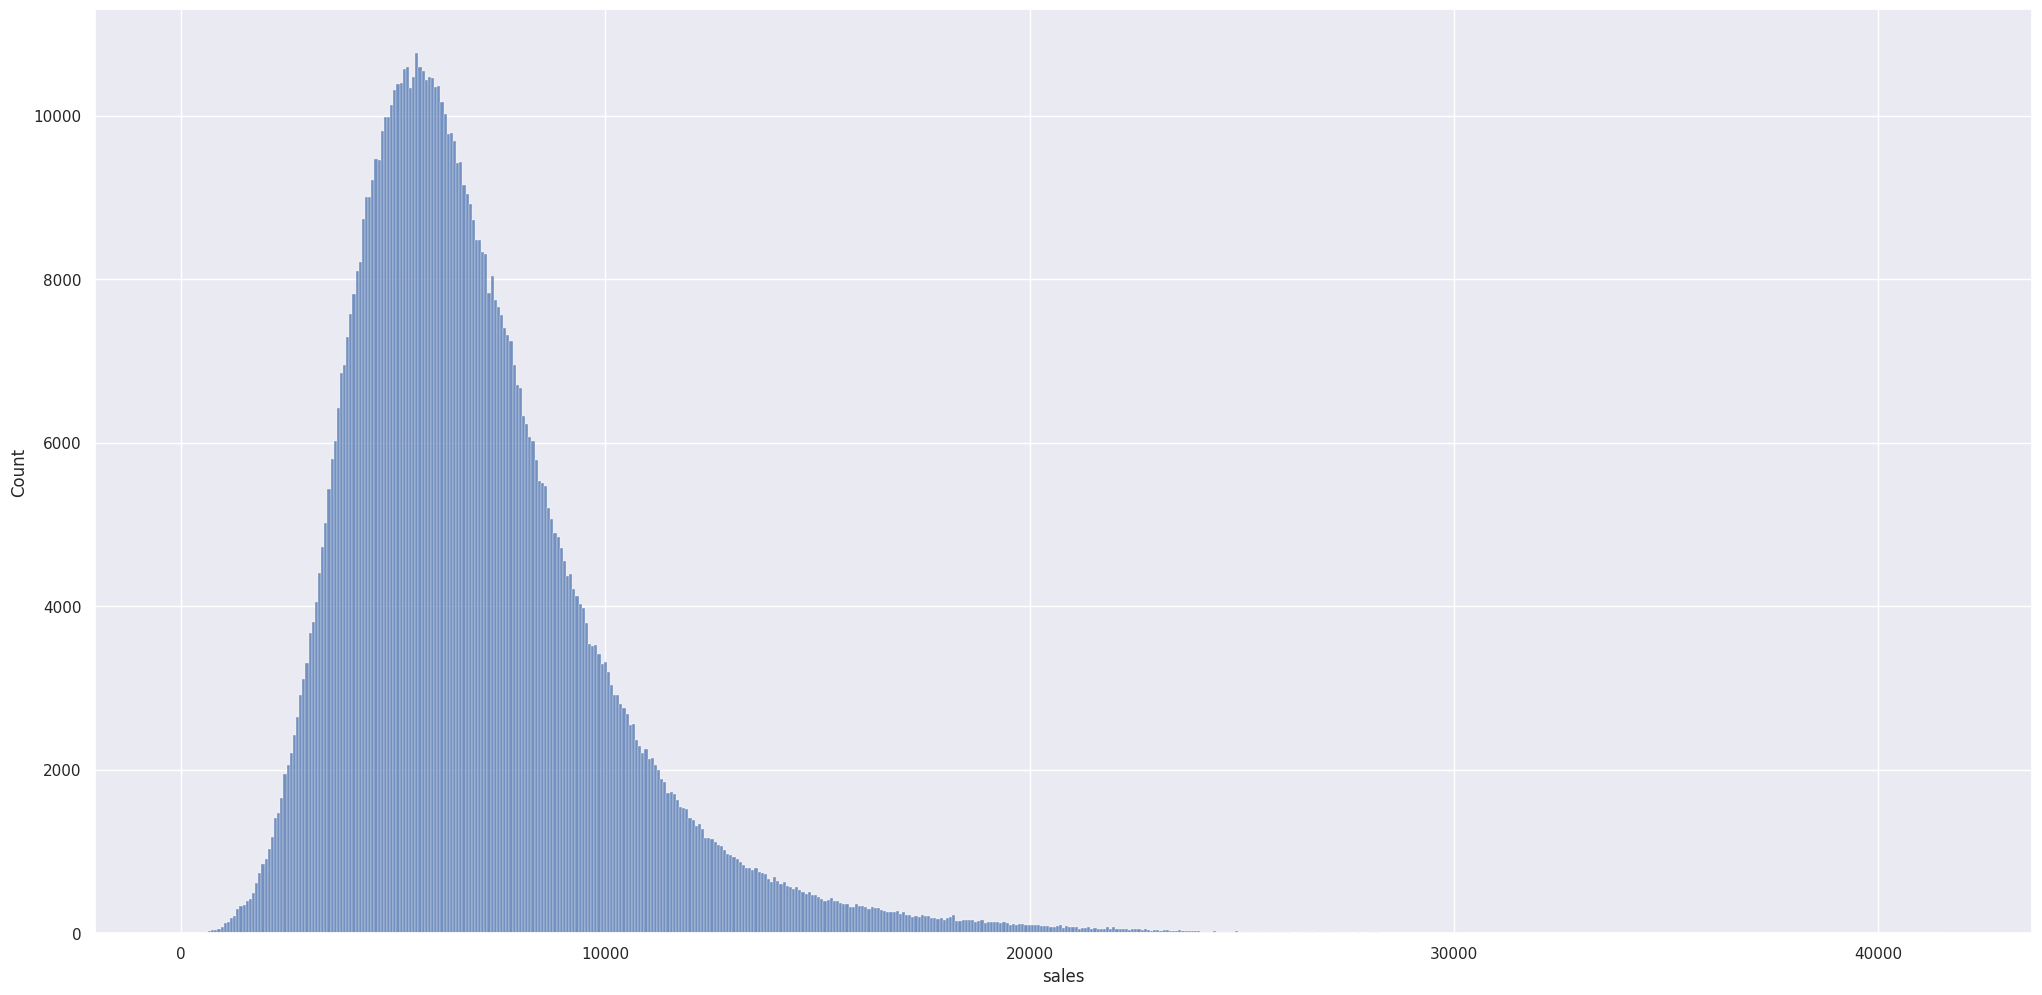

In [4]:
sns.histplot(df4['sales'], kde=False)

### Shape of the Distribution:
The histogram shows a **right-skewed (positively skewed)** distribution. This is evident as the majority of the sales data is concentrated on the left side of the plot with a long tail extending to the right.

### Central Tendency:
The peak of the histogram indicates that a large number of sales values are clustered around the lower end, specifically between **0 and 10,000**. This peak represents the **mode**, the most frequently occurring sales value range in the dataset.

### Dispersion:
The spread of the data points indicates **variability** in sales values. Most of the sales values fall below **20,000**, with a smaller number extending up to around **40,000**. The right tail suggests there are a few instances of **very high sales**, indicating **outliers or extreme values**.

### Count and Frequency:
The **y-axis** represents the count (frequency) of occurrences for each sales value range. The highest bar in the histogram shows that there are around **10,000 occurrences** of sales values in the lower range (between **0 and 10,000**).

### Business Insights:
The majority of sales transactions are lower in value, with a few high-value transactions. This can imply a large volume of small sales and a few large sales.

### Modeling Considerations:
When building predictive models, the skewness and presence of outliers need to be considered. Techniques like log transformation might be applied to normalize the data distribution.


## 9.2 Numerical Variables

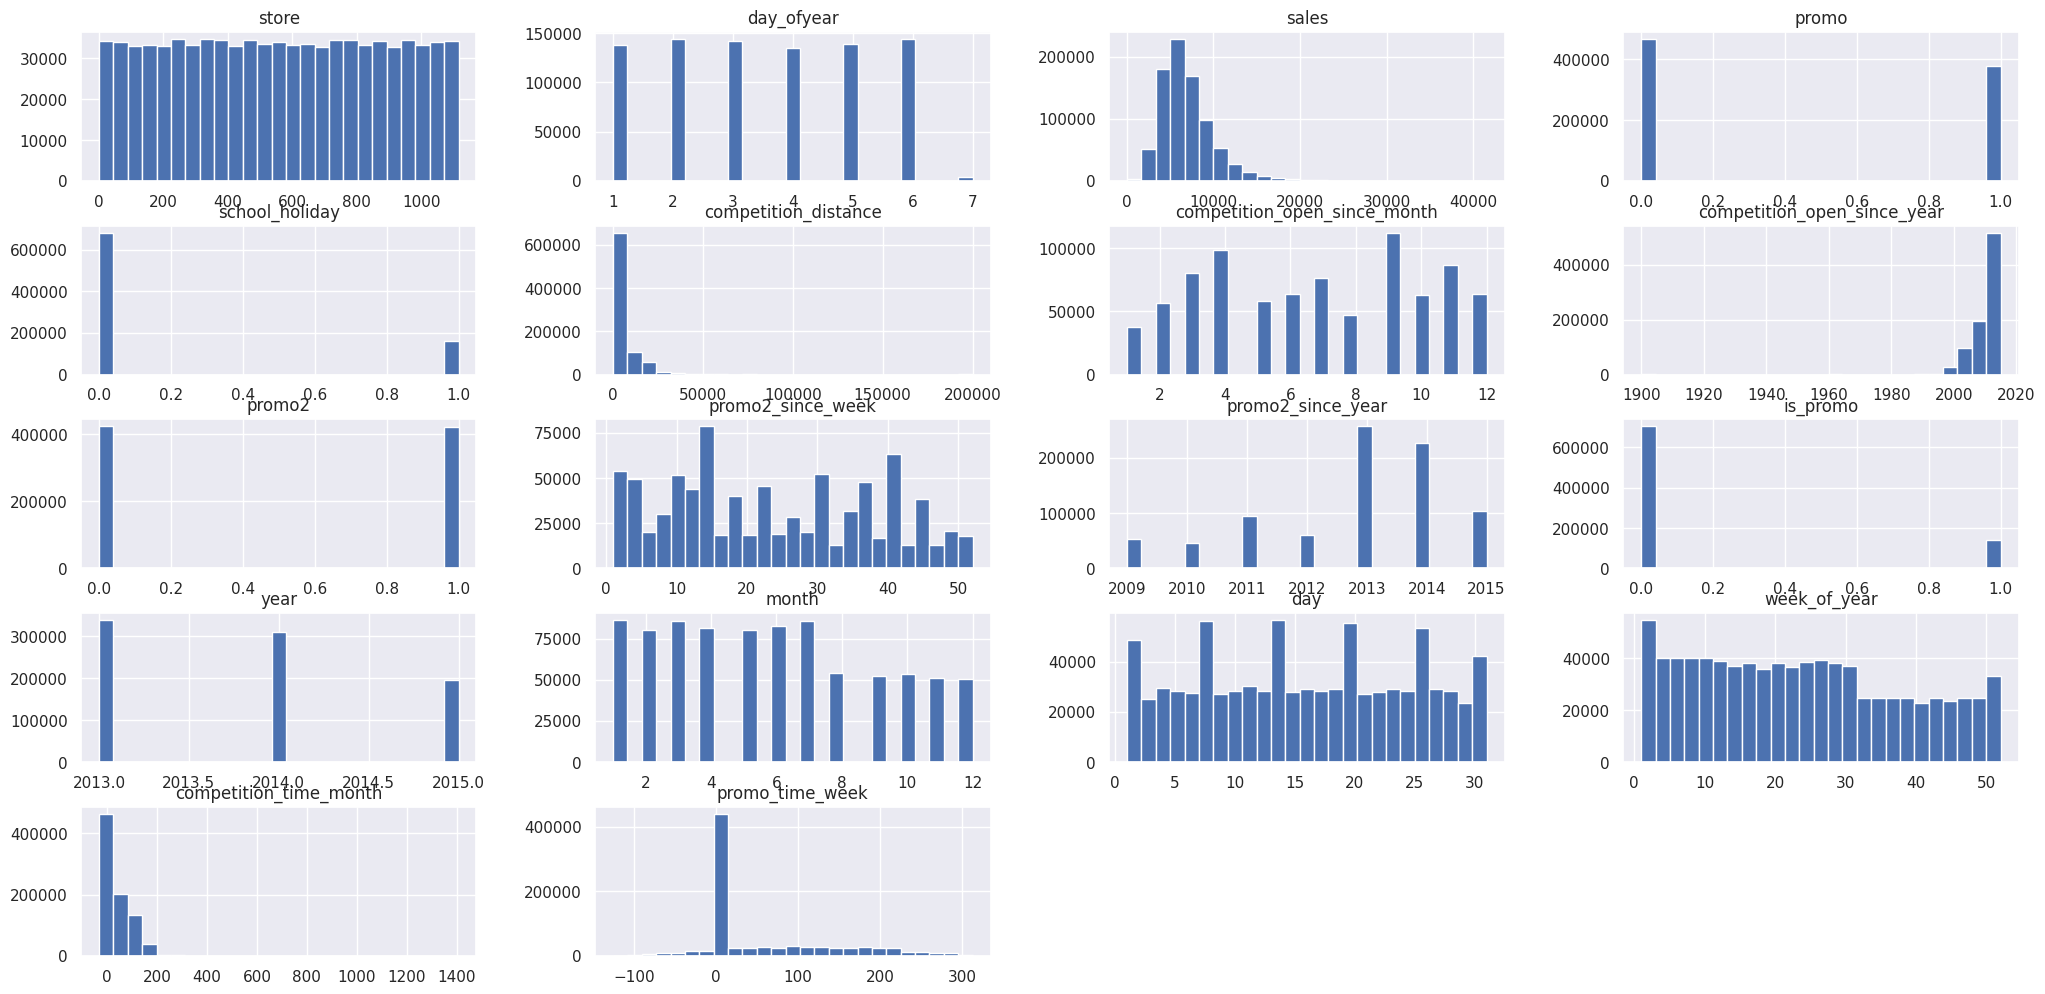

In [5]:
#define numerical and categorical attributes
num_attributes=df4.select_dtypes(include=['int64', 'float64'])
cat_attributes=df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
num_attributes.hist(bins=25);

## 9.3 Categorical Variables

<Axes: xlabel='sales', ylabel='Density'>

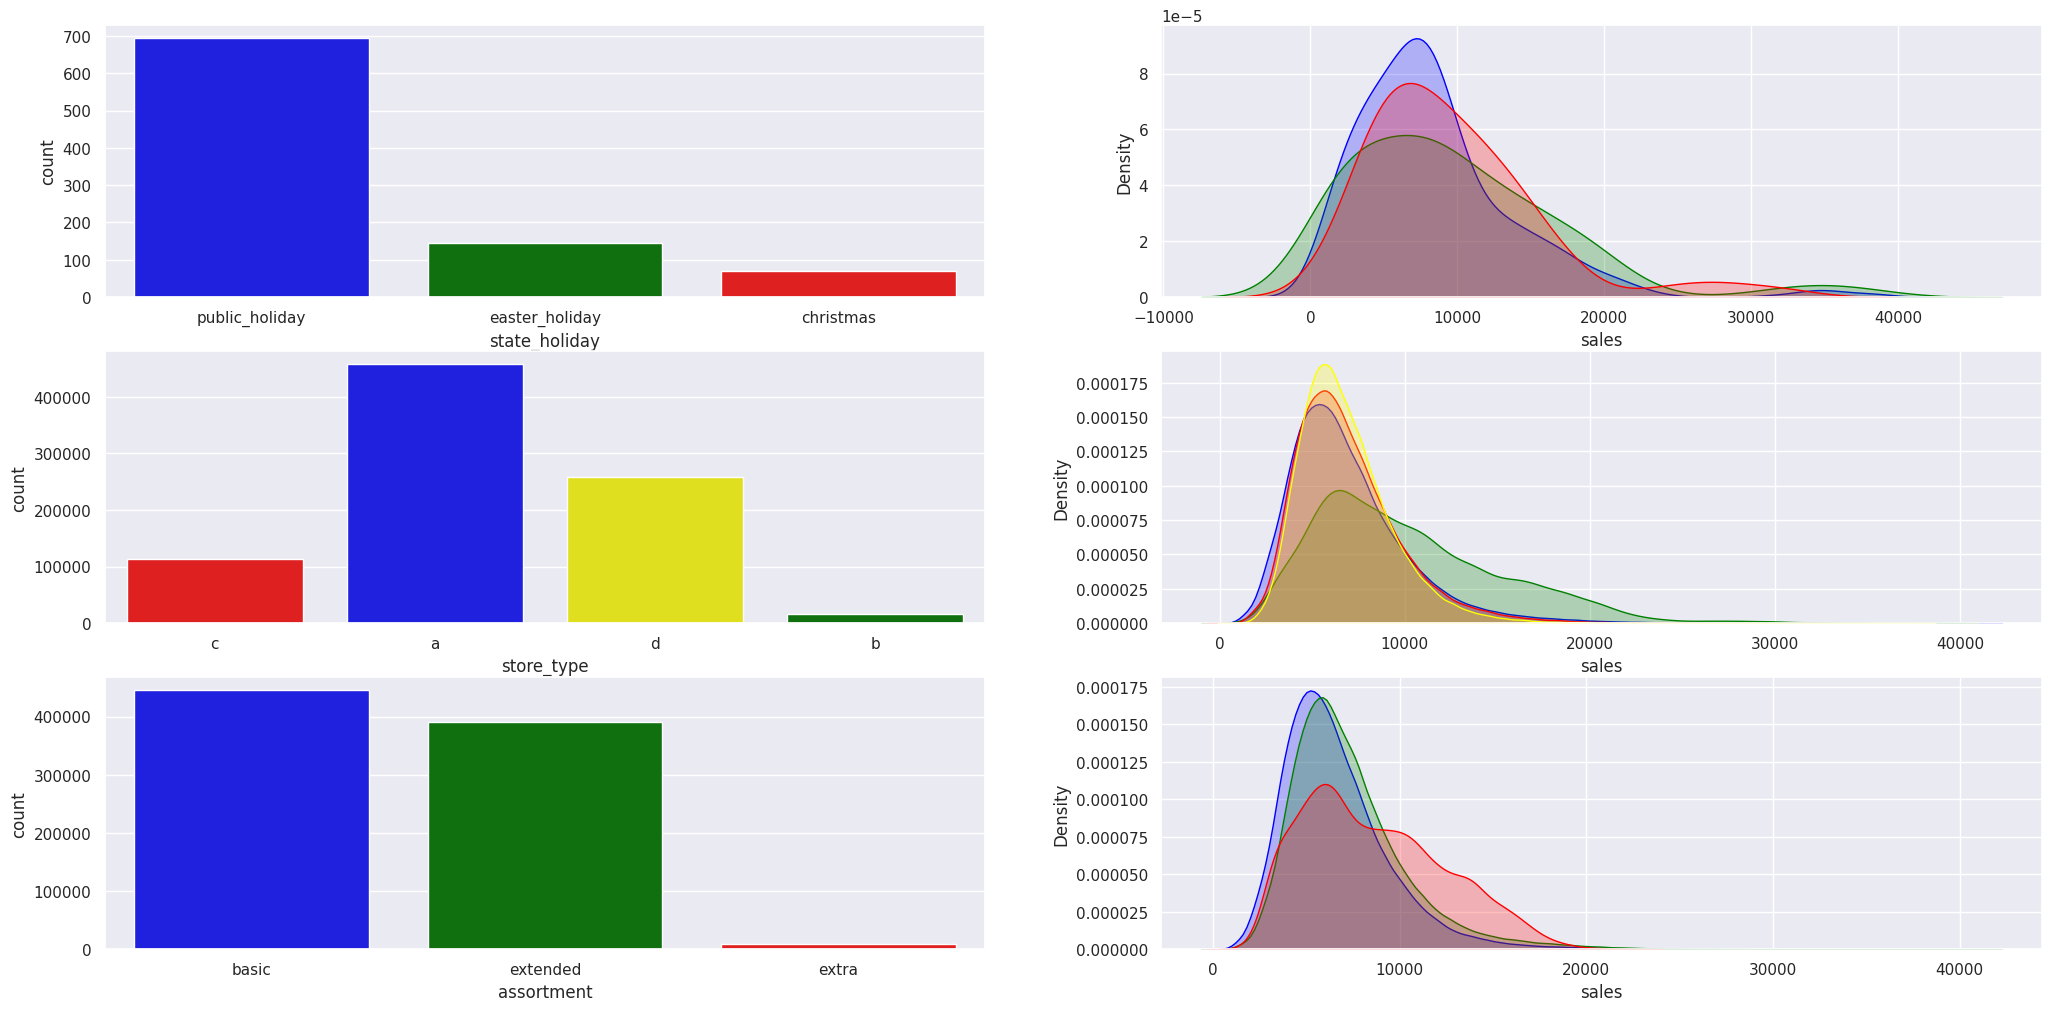

In [6]:

#state_holiday



# Define a color palette
palette={'public_holiday':'blue', 'easter_holiday':'green', 'christmas':'red'}

plt.subplot(3,2,1)
a=df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday', palette=palette, hue='state_holiday')

plt.subplot(3,2,2)

sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday',fill=True, color=palette['public_holiday'])

sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',fill=True, color=palette['easter_holiday'])

sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',fill=True, color=palette['christmas'])

# Store Type

# Define a color palette
palette={'a':'blue', 'b':'green', 'c':'red', 'd':'yellow'}

plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', palette=palette, hue='store_type')

plt.subplot(3,2,4)

sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',fill=True, color=palette['a'])

sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',fill=True, color=palette['b'])

sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',fill=True, color=palette['c'])

sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',fill=True, color=palette['d'])

# assortment

# Define a color palette
palette={'basic':'blue', 'extended':'green', 'extra':'red'}

plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', palette=palette, hue='assortment')

plt.subplot(3,2,6)

sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',fill=True, color=palette['basic'])

sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended',fill=True, color=palette['extended'])

sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',fill=True, color=palette['extra'])




### Interpretation of the Plots

#### 1. State Holiday

**Count Plot**:
- **Public Holiday**: The majority of data points correspond to public holidays, with a count of over 700.
- **Easter Holiday**: A smaller number of data points are associated with Easter holidays, with a count around 100.
- **Christmas**: There are fewer data points for Christmas, with a count around 50.

**KDE Plot**:
- **Public Holiday**: Sales during public holidays show a distribution with a peak around 10,000 and a long tail extending up to 40,000.
- **Easter Holiday**: Sales during Easter holidays are more concentrated, with a peak around 8,000 and fewer high-value sales.
- **Christmas**: Sales during Christmas also peak around 8,000 but have a more significant spread compared to Easter holidays.

#### 2. Store Type

**Count Plot**:
- **Type A**: The most common store type, with a count of over 400,000.
- **Type D**: The second most common, with a count around 300,000.
- **Type C**: Less common, with a count around 100,000.
- **Type B**: Very few data points, with a count below 50,000.

**KDE Plot**:
- **Type A**: Sales peak around 8,000, with a long tail extending up to 40,000.
- **Type B**: Sales have a similar peak around 10,000, but the tail is not as long.
- **Type C**: Sales peak around 5,000 and have a narrower distribution.
- **Type D**: Sales show a broader distribution with a peak around 12,000.

#### 3. Assortment

**Count Plot**:
- **Basic**: The most common assortment type, with a count over 400,000.
- **Extended**: The second most common, with a count around 300,000.
- **Extra**: Very few data points, with a count below 50,000.

**KDE Plot**:
- **Basic**: Sales for basic assortment peak around 8,000, with a long tail extending up to 40,000.
- **Extended**: Sales for extended assortment peak around 10,000 and show a broader distribution.
- **Extra**: Sales for extra assortment peak around 5,000 with a narrow distribution.

### Summary

- **State Holiday**: Sales distributions vary significantly by holiday type, with public holidays showing higher sales variability and peaks compared to Easter and Christmas.
- **Store Type**: Type A stores have the highest number of sales, followed by Type D. Type B and C stores have fewer sales but show different distribution patterns.
- **Assortment**: Basic assortments are the most common and show a wide range of sales values, while extended assortments show higher peaks and extra assortments are less common with lower sales peaks.

### Conclusions

- Sales are highest and most variable during public holidays.
- Store type A and D are the most common and have higher sales, suggesting they might be more effective or popular.
- Basic assortments are prevalent and show significant sales, but extended assortments also perform well in terms of peak sales values.
- These insights can help in understanding sales patterns and making informed decisions regarding holiday promotions, store management, and assortment strategies.


# 10 Hypothesys
## 10.1 Mind Map for Hypothesis

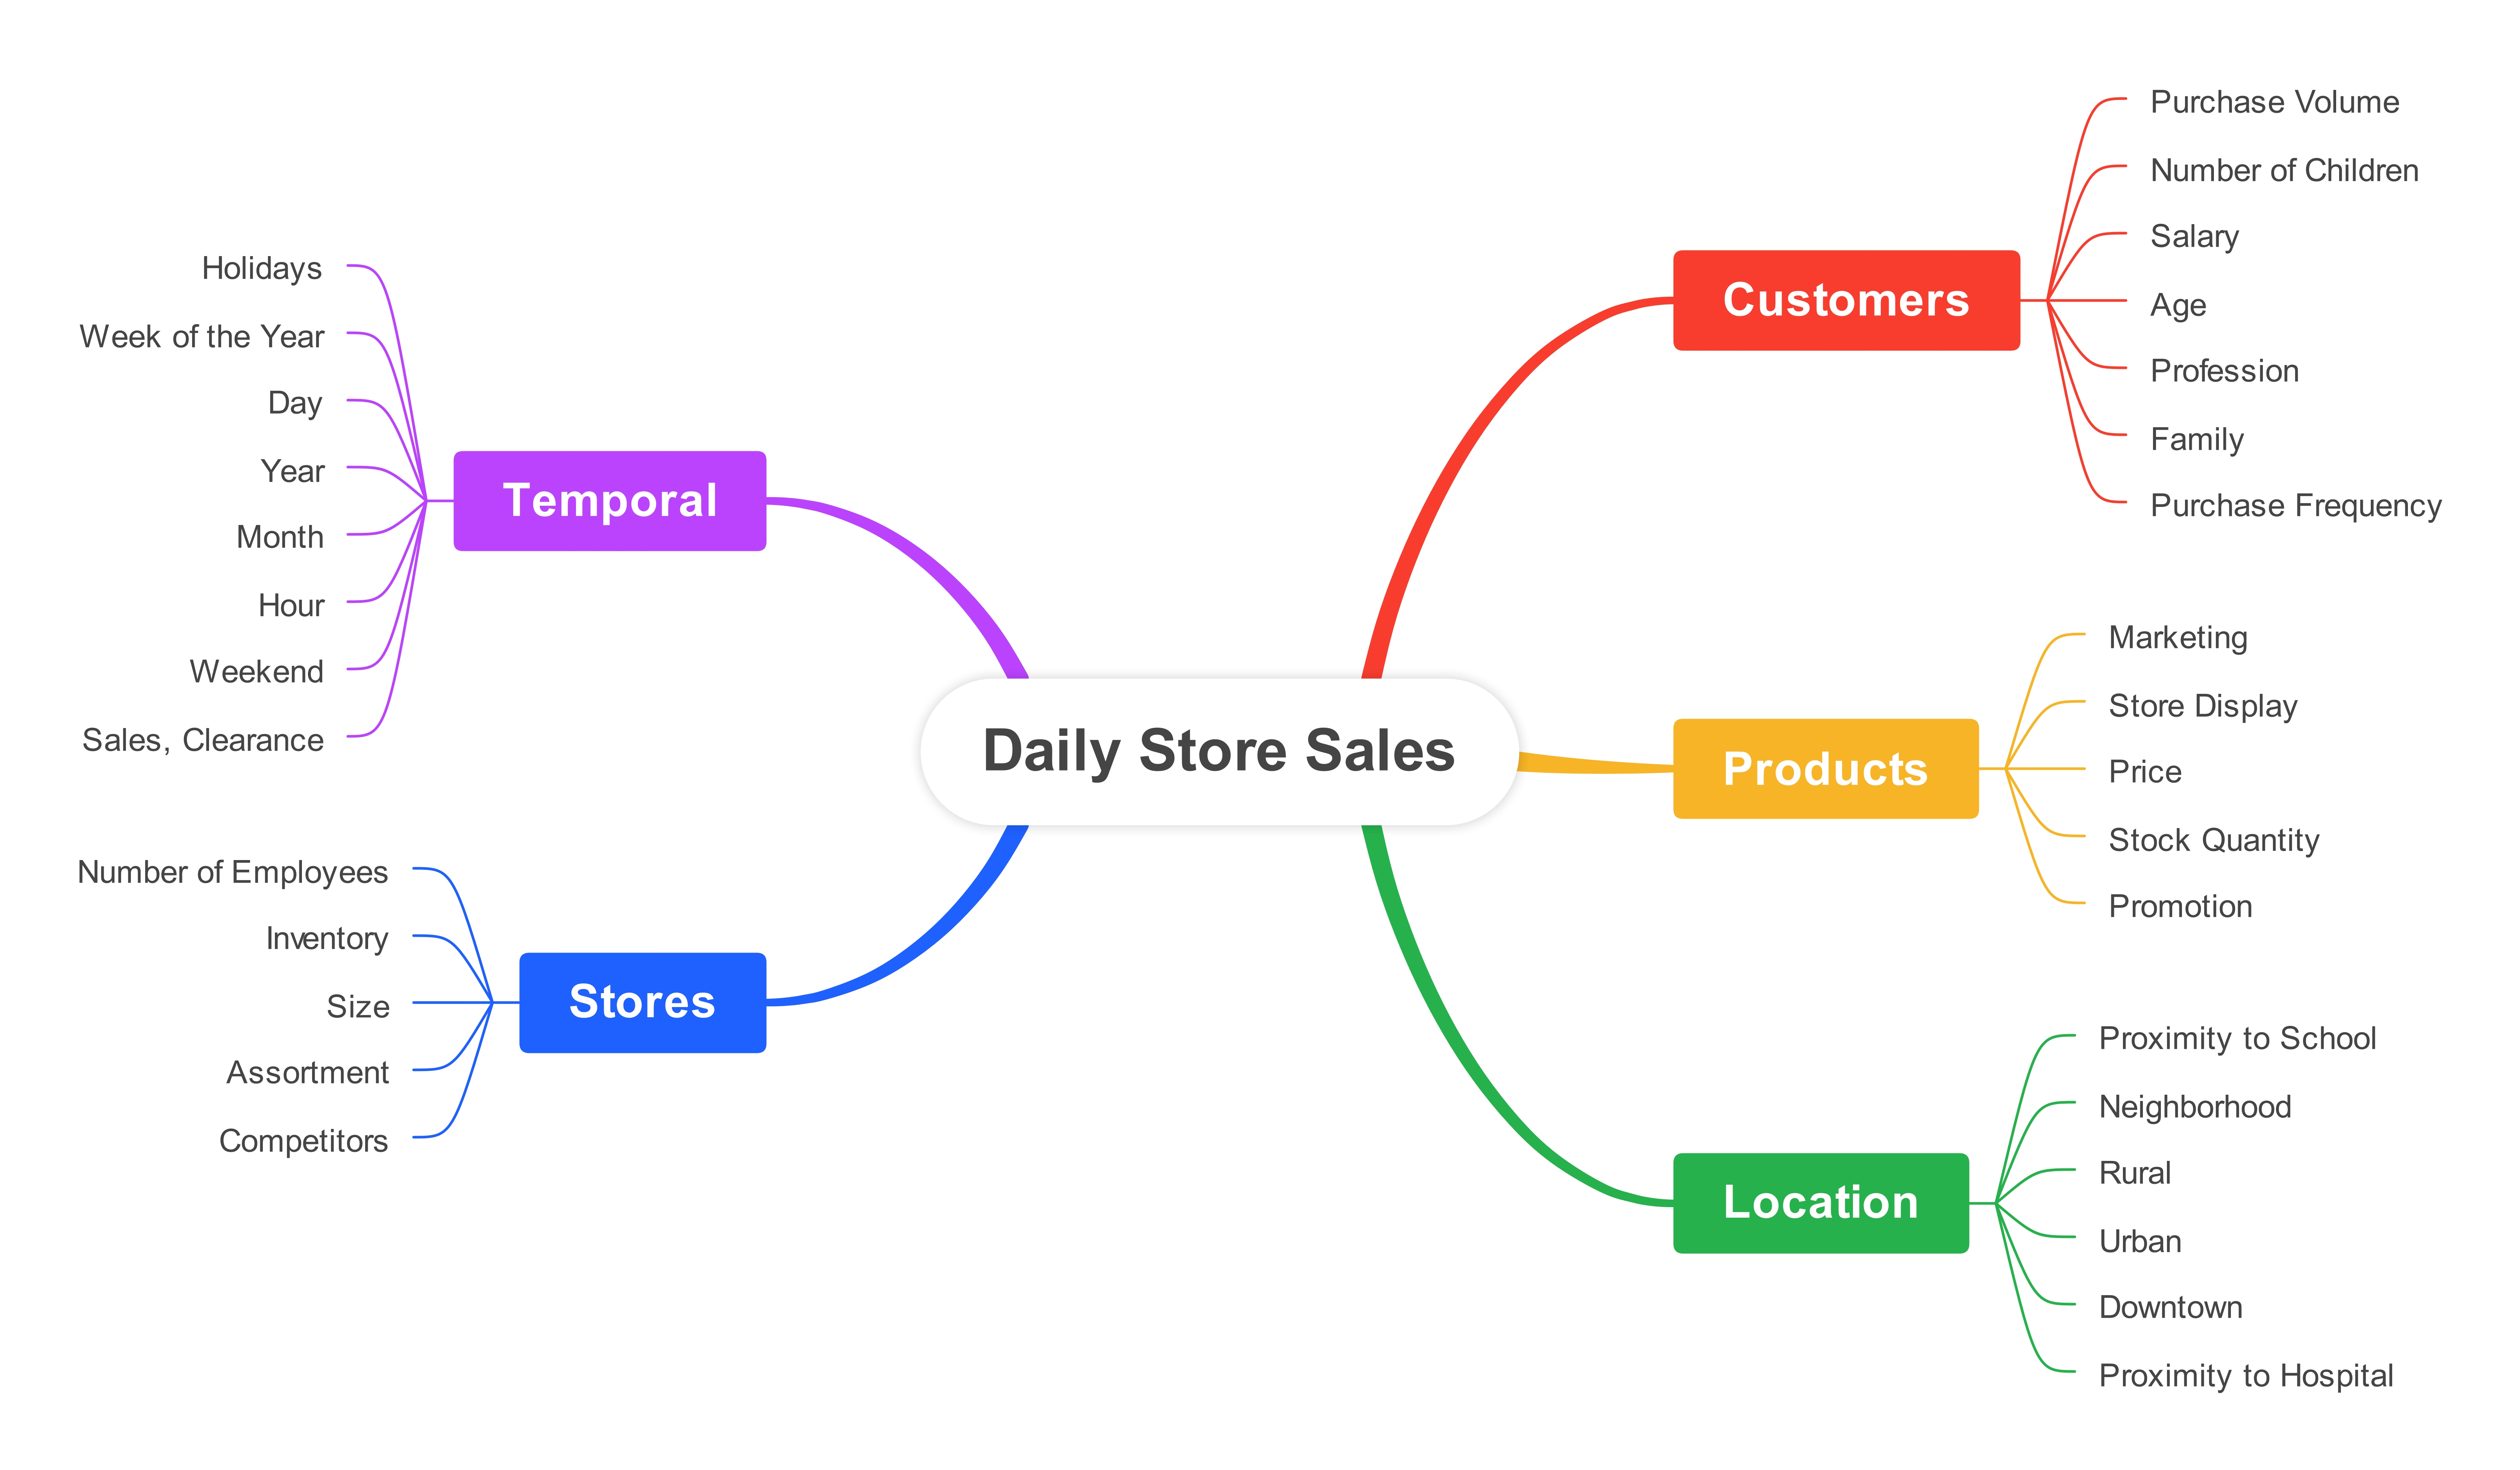

In [7]:
image_path = '/home/thiago_souza/project_cds/rossmann_case/img/MindMapHypothesis.jpg'
display(Image(filename=image_path))

10.2 Hypothesis
# Creation of Hypotheses

## Store Hypotheses
1. Stores with a larger number of employees should sell more.
2. Stores with greater stock capacity should sell more.
3. Larger stores should sell more.
4. Stores with a greater assortment should sell more.
5. Stores with closer competitors should sell less.
6. Stores with competitors for a longer time should sell more.

## Product Hypotheses
1. Stores that invest more in marketing should sell more.
2. Stores with greater product exposure should sell more.
3. Stores with lower-priced products should sell more.
4. Stores with more aggressive promotions (bigger discounts) should sell more.
5. Stores with promotions active for a longer time should sell more.
6. Stores with more promotion days should sell more.
7. Stores with more consecutive promotions should sell more.

## Time Hypotheses
1. Stores open during the Christmas holiday should sell more.
2. Stores should sell more over the years.
3. Stores should sell more in the second half of the year.
4. Stores should sell more after the 10th of each month.
5. Stores should sell less on weekends.
6. Stores should sell less during school holidays.

#  Final List of Hypotheses
1. Stores with a greater assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with competitors for a longer time should sell more.
4. Stores with promotions active for a longer time should sell more.
5. Stores with more promotion days should sell more.
6. Stores with more consecutive promotions should sell more.
7. Stores open during the Christmas holiday should sell more.
8. Stores should sell more over the years.
9. Stores should sell more in the second half of the year.
10. Stores should sell more after the 10th of each month.
11. Stores should sell less on weekends.
12. Stores should sell less during school holidays.


# Bivariate Analysis


## H1 Stores with a greater assortment should sell more. = FALSE

<Axes: xlabel='year_week'>

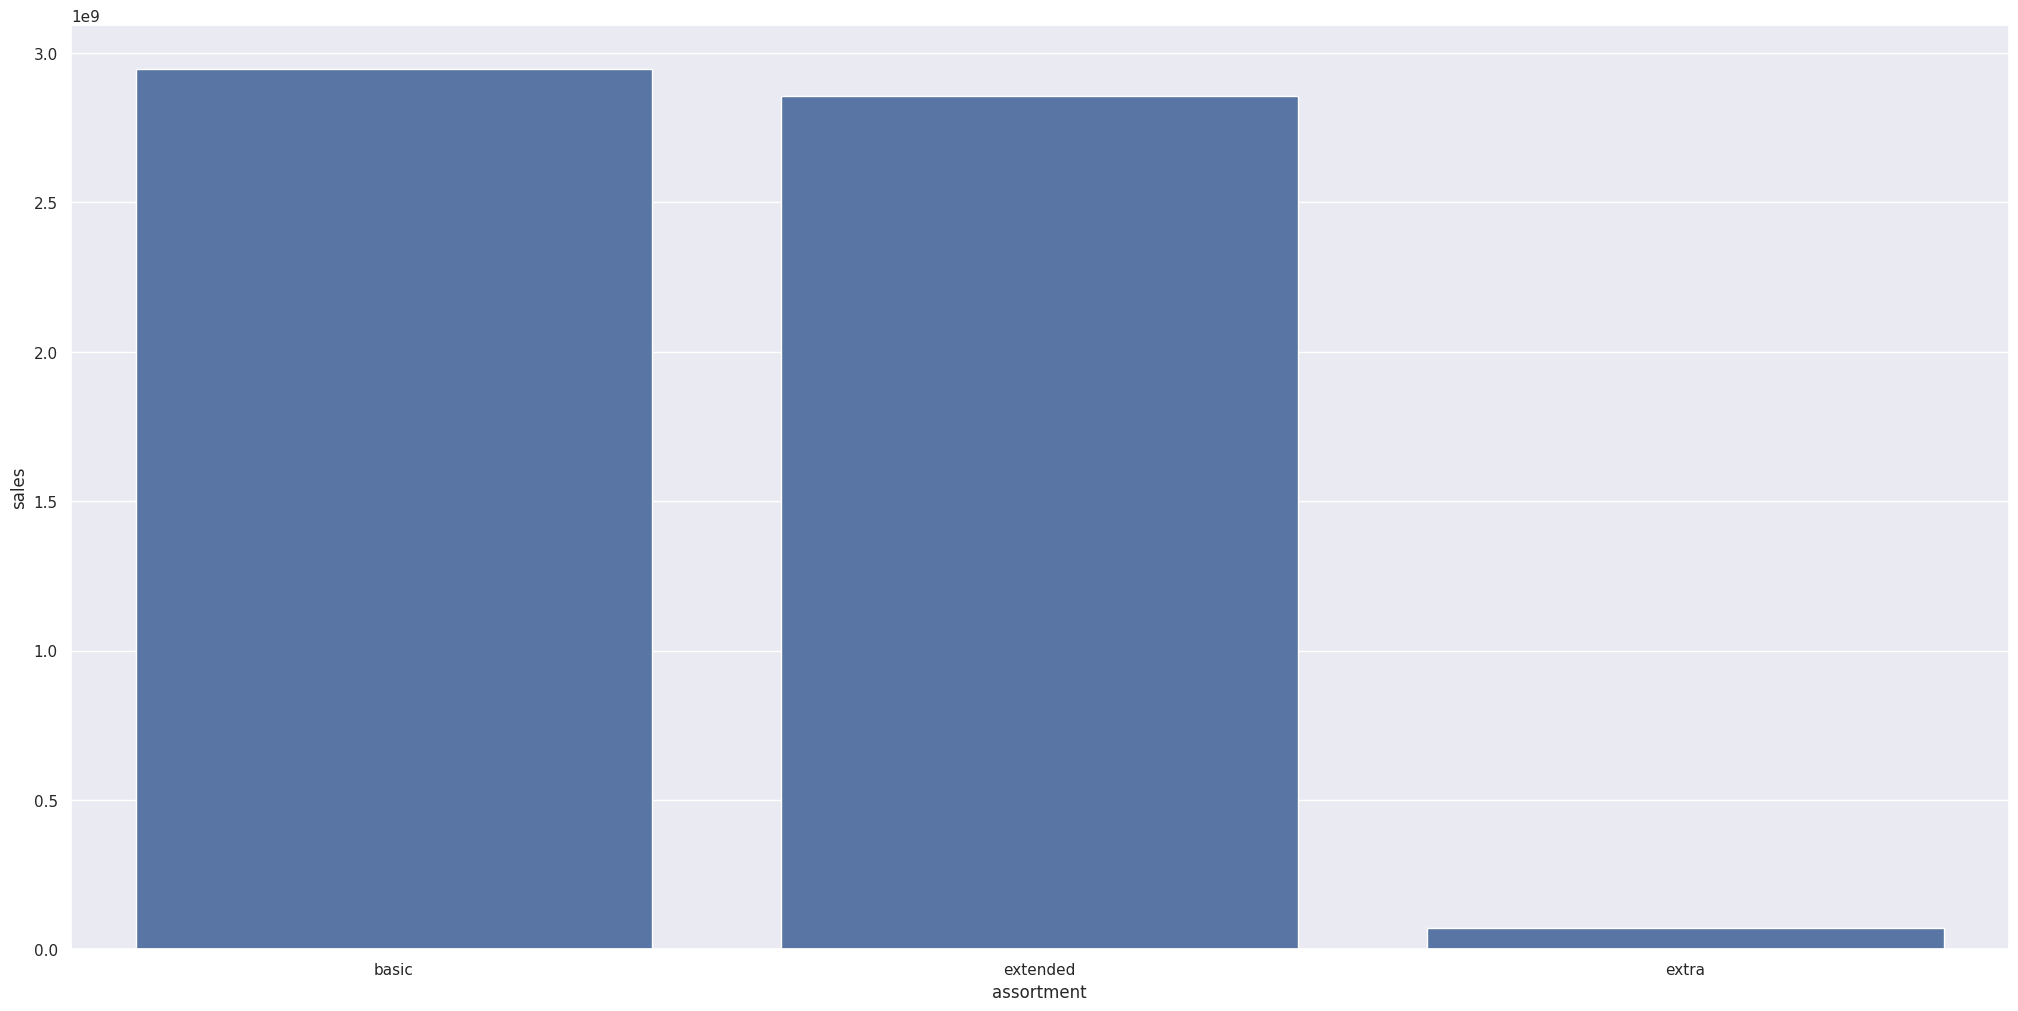

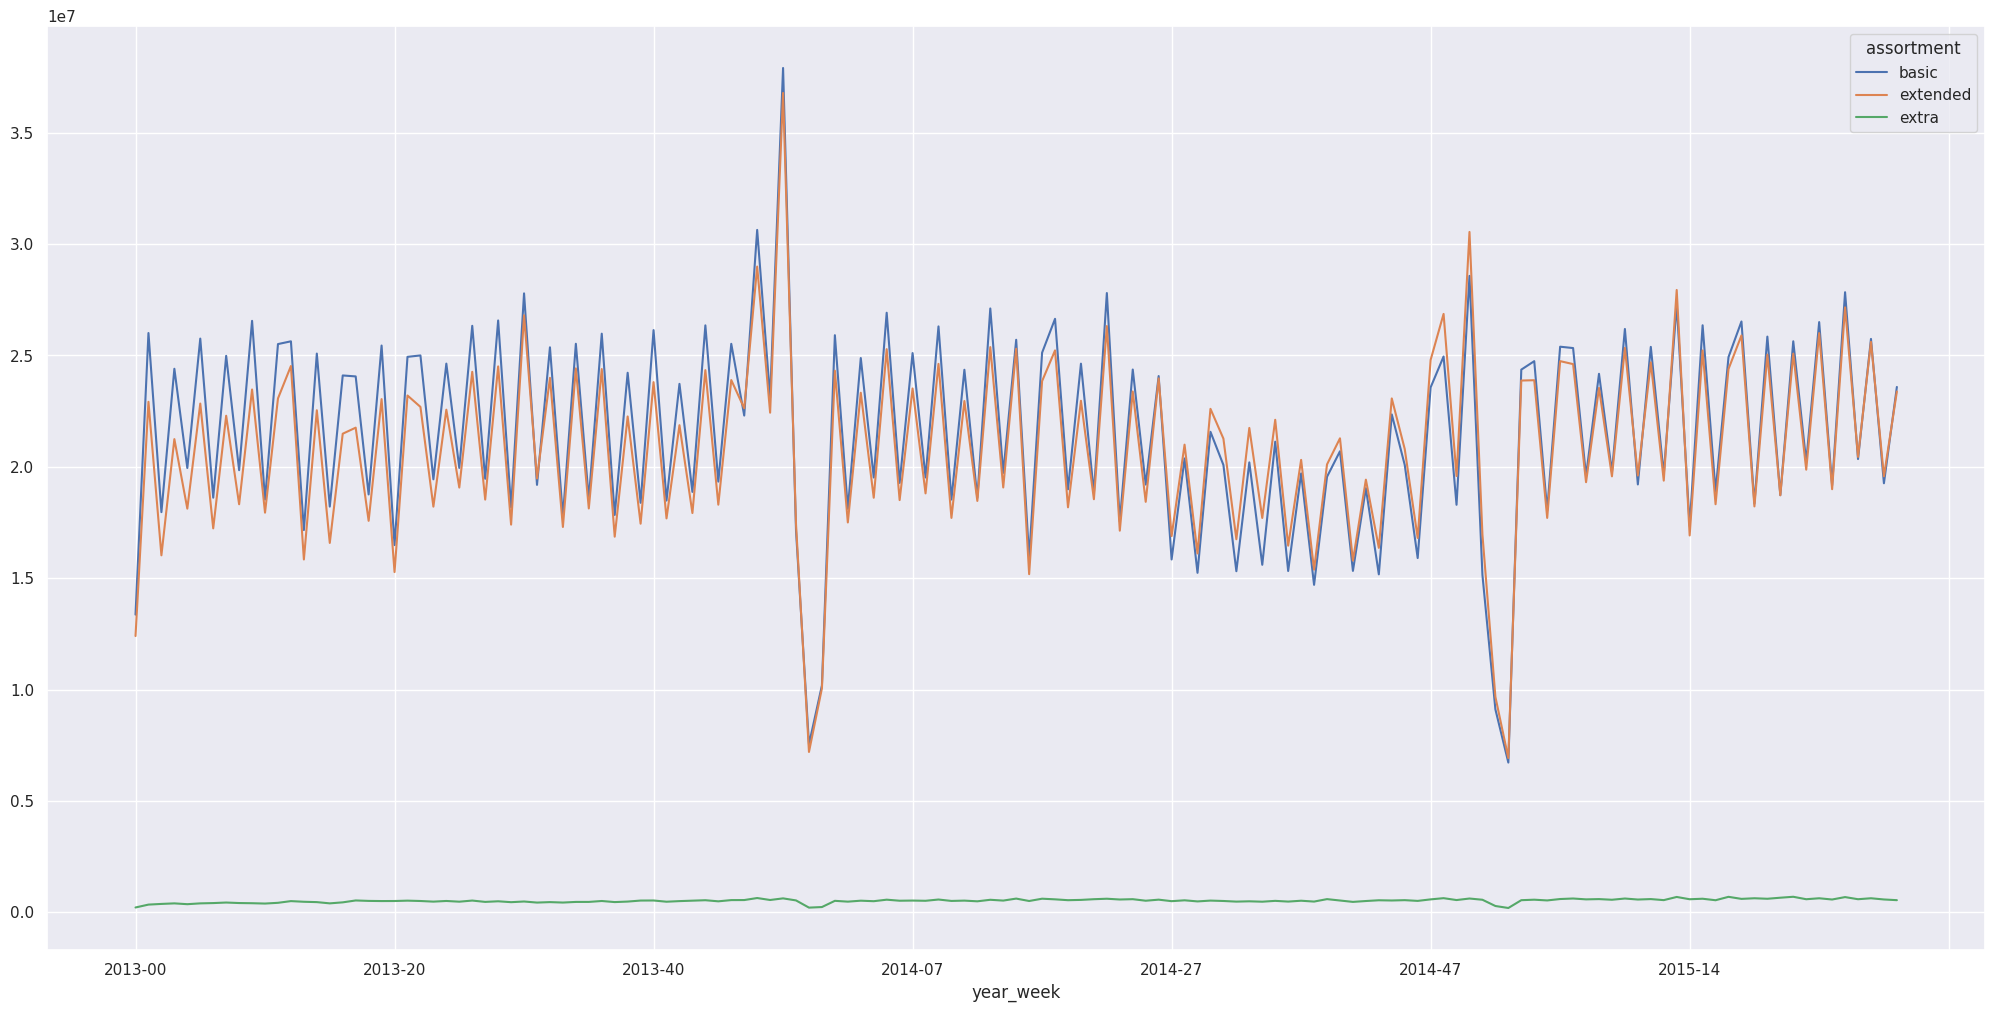

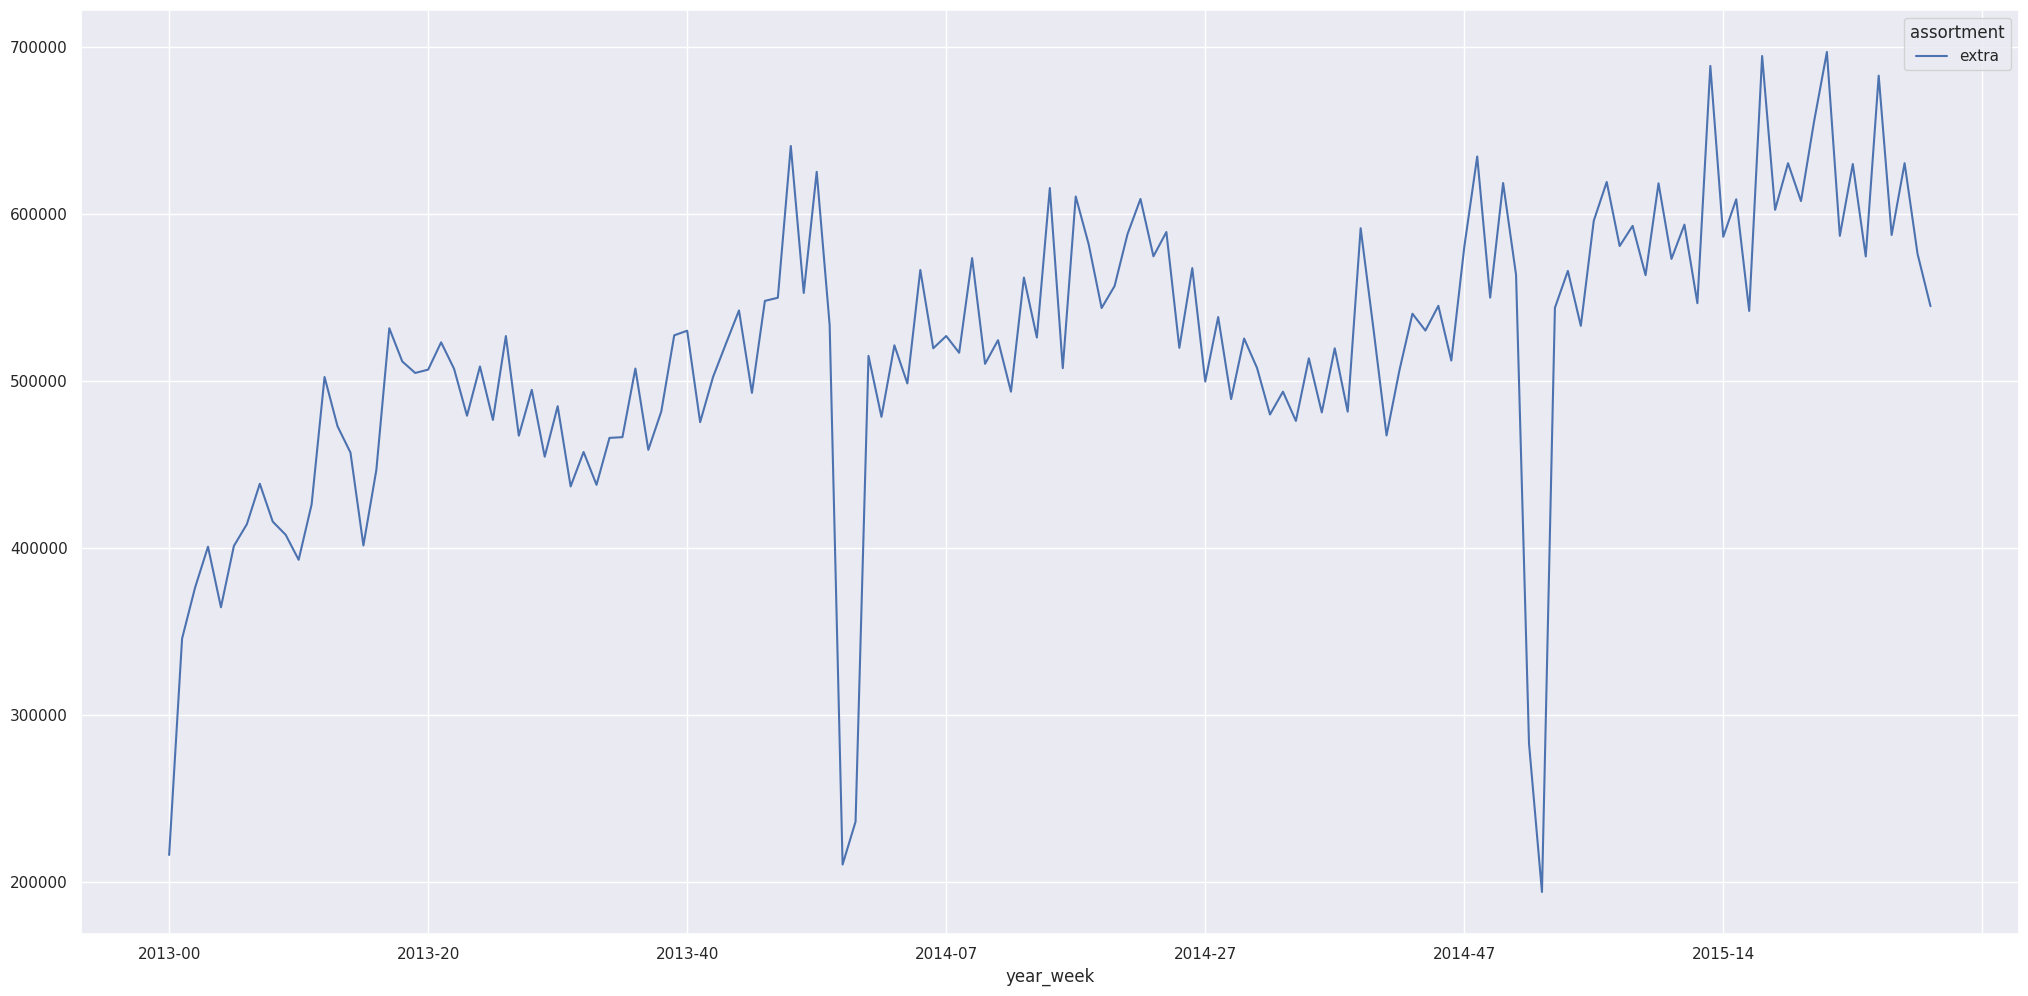

In [8]:
aux1= df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2=df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values= 'sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot()

# Sales Distribution: The bar plot clearly indicates that stores with Basic and Extended assortments have significantly higher total sales compared to those with the Extra assortment.
# Sales Trends: The time series plots reveal that the Basic and Extended assortments not only have higher sales but also exhibit similar and stable sales trends over time.
# Impact of Assortment: The Extra assortment consistently underperforms, suggesting that increasing the assortment alone may not lead to higher sales. Other factors such as marketing, pricing strategies, and customer preferences likely play a role.

### Abstract

The provided analysis evaluates the correlation between store assortment and sales, questioning the hypothesis that stores with a greater assortment should sell more. The visualization of sales data grouped by assortment categories and over time does not support this hypothesis. Below is an interpretation based on the provided data visualizations and the underlying analysis steps.

### Interpretation of Visualizations

1. **Total Sales by Assortment Category**:
   - The bar plot shows that "basic" and "extended" assortments have significantly higher total sales compared to the "extra" assortment.
   - This disproves the hypothesis that stores with a greater assortment (i.e., "extra") should have higher sales. Instead, "basic" and "extended" assortments are associated with higher sales.

2. **Weekly Sales Trends by Assortment**:
   - The line plot shows sales trends over time for each assortment category.
   - The "extra" assortment consistently shows lower sales compared to "basic" and "extended" assortments.
   - The sales for "basic" and "extended" assortments follow similar trends, often overlapping, indicating no significant advantage for the "extra" assortment over time.

3. **Detailed Sales Trends for "Extra" Assortment**:
   - The separate line plot for the "extra" assortment illustrates its sales trend over time.
   - This plot further confirms that sales for the "extra" assortment are consistently lower than the other categories, even though there might be some fluctuations.

### Conclusion

Based on the visualizations, the hypothesis that stores with a greater assortment should sell more is not supported by the data. The "basic" and "extended" assortments outperform the "extra" assortment in total sales. This analysis suggests that other factors may influence sales more significantly than the breadth of assortment.




## H2 Stores with closer competitors should sell less. FALSE

Text(0.5, 1.0, 'Correlation Heatmap')

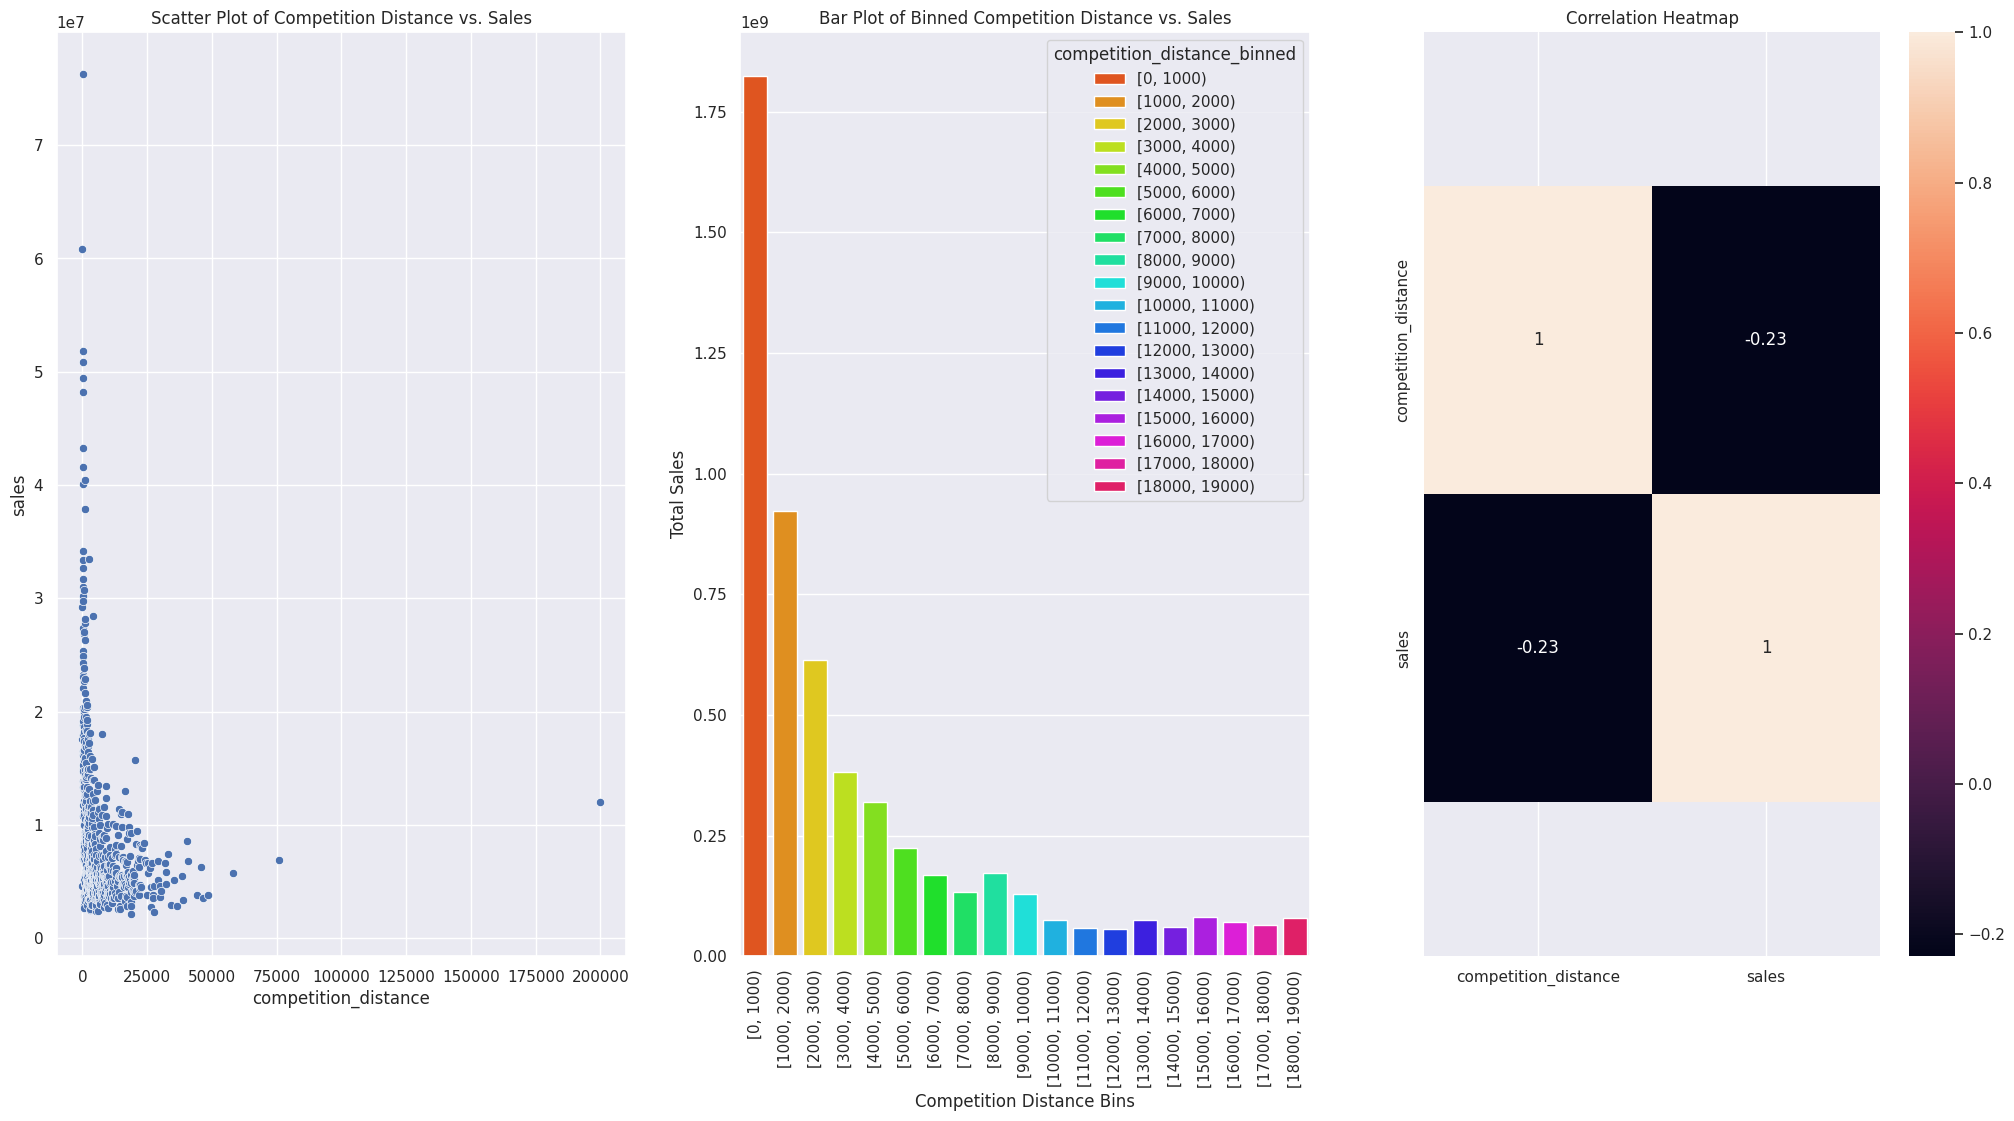

In [9]:
# Group by competition_distance and sum the sales
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Scatter plot of competition_distance vs. sales
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Scatter Plot of Competition Distance vs. Sales')

# Create bins and group by binned competition_distance
bins = list(np.arange(0, 20000, 1000))
colors = sns.color_palette('hsv', len(bins) - 1)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins, right=False, include_lowest=True)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).sum().reset_index()

# Bar plot of binned competition_distance vs. sales
plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette=colors, hue='competition_distance_binned', dodge=False)
plt.xticks(rotation=90)
plt.title('Bar Plot of Binned Competition Distance vs. Sales')
plt.xlabel('Competition Distance Bins')
plt.ylabel('Total Sales')

# Heatmap of competition_time_month vs. sales
plt.subplot(1, 3, 3)
corr_matrix = aux1.drop(columns=['competition_distance_binned']).corr(method='pearson')
x = sns.heatmap(corr_matrix, annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation Heatmap')




### Interpretation

#### 1. Scatter Plot of Competition Distance vs. Sales
- **Plot Description**: The scatter plot shows the relationship between `competition_distance` (the distance to the nearest competitor) and `sales`.
- **Insights**:
  - The plot reveals that stores with a smaller competition distance tend to have higher sales.
  - There is a noticeable decline in sales as the competition distance increases, but some high sales are observed even at greater distances, suggesting other factors might also influence sales.

#### 2. Bar Plot of Binned Competition Distance vs. Sales
- **Plot Description**: The bar plot groups `competition_distance` into bins and sums the sales for each bin. Each bin represents a range of competition distances.
- **Insights**:
  - The first bin (0 to 1000 meters) has significantly higher sales compared to other bins. This indicates that stores with competitors very close by tend to have higher sales.
  - As the distance increases, sales generally decrease, but the pattern is not strictly linear, indicating other factors might play a role.
  - The variation in sales within different bins suggests that proximity to competitors is a significant but not sole determinant of sales performance.

#### 3. Correlation Heatmap
- **Plot Description**: The heatmap displays the Pearson correlation coefficients between `competition_distance` and `sales`.
- **Insights**:
  - The correlation coefficient between `competition_distance` and `sales` is -0.23, indicating a weak negative correlation. This means that, generally, as the competition distance increases, sales tend to decrease, but the relationship is not strong.
  - The heatmap visually reinforces that the relationship between competition distance and sales exists but is not highly pronounced.

### Overall Interpretation
- The analysis suggests that stores with closer competitors tend to have higher sales, but the relationship is not strongly linear. There are other contributing factors to sales performance that should be considered.
- The correlation heatmap supports the observation from the scatter plot and bar plot, indicating a weak negative correlation between competition distance and sales.
- This analysis provides a foundation for further exploration into how various factors influence sales and how strategies could be tailored to optimize store performance based on competitive landscape.


## H3 Stores with competitors for a longer time should sell more. FALSE

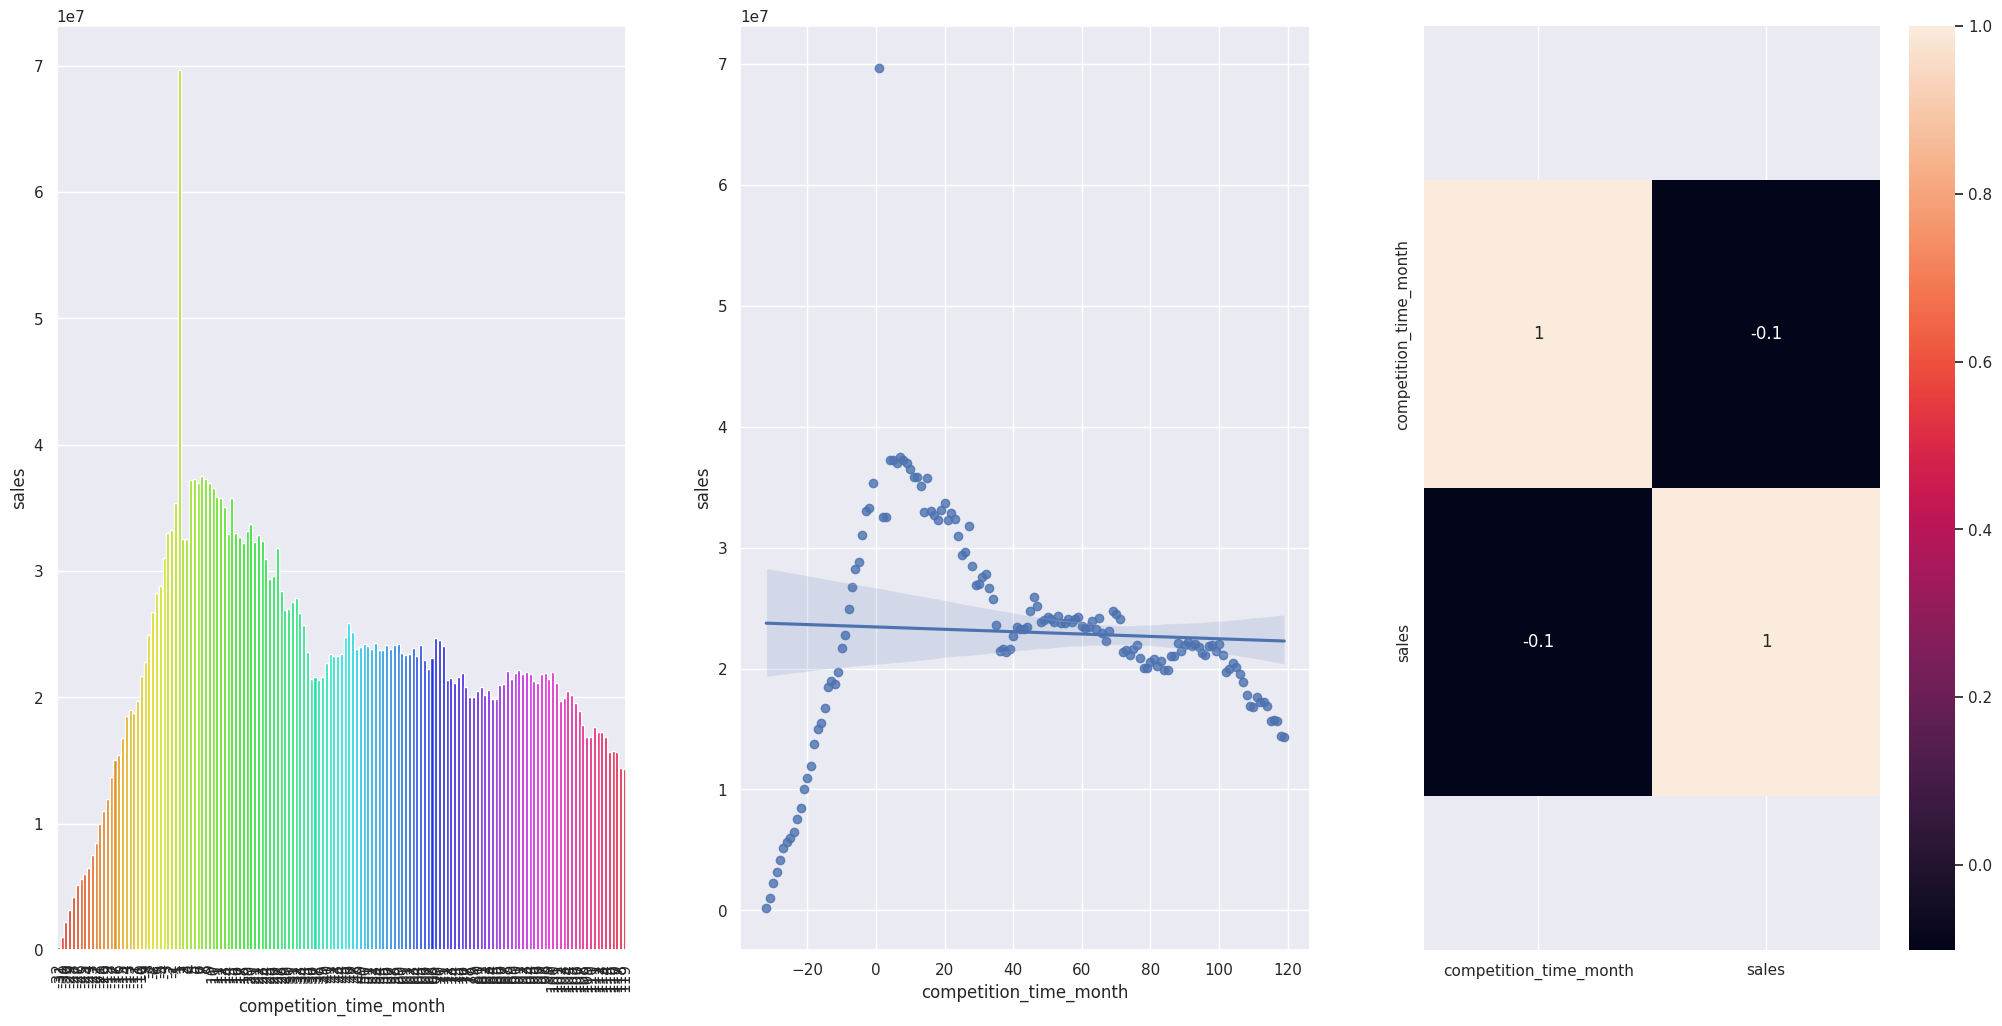

In [10]:
# Subplot 1: Bar Plot
plt.subplot(1,3,1)
bins = list(np.arange(0, 120, 10))


# Grouping data by competition_time_month and summing sales
aux1= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Filter the grouped data to exclude 0 and values >= 120
aux2=aux1[ (aux1['competition_time_month']<120)&(aux1['competition_time_month']!=0)]

# Create colors after filtering
colors = sns.color_palette('hsv', len(aux2['competition_time_month'].unique()))

# Creating the bar plot
sns.barplot(x='competition_time_month', y='sales', data=aux2, palette=colors, hue='competition_time_month',legend=False);
plt.xticks(rotation=90);

# Subplot 2: Regression Plot
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

# Subplot 3: Correlation Heatmap
plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top=x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);


## Abstract
The visualizations aim to analyze the relationship between the competition time in months (`competition_time_month`) and store sales. The hypothesis tested is whether stores with competitors for a longer duration should have different sales patterns. The analysis uses bar plots, regression plots, and correlation heatmaps to explore this relationship. Below is the interpretation based on the visualizations.

## Interpretation of Visualizations

### Bar Plot
- The bar plot shows total sales by `competition_time_month` for stores that have had competition for different durations.
- Sales appear to increase initially, peaking around the 20-month mark, and then show a fluctuating pattern with no clear trend beyond that.
- This indicates that sales may initially increase with the presence of competition but then stabilize or decrease over time.

### Regression Plot
- The regression plot displays the relationship between `competition_time_month` and sales.
- The regression line shows a slight downward trend, suggesting a weak negative correlation between the duration of competition and sales.
- However, the plot also shows a lot of variability and some outliers, indicating that other factors may be influencing sales.

### Correlation Heatmap
- The heatmap shows the Pearson correlation coefficients between `competition_time_month` and sales.
- The correlation coefficient is -0.1, indicating a weak negative correlation.
- This supports the observation from the regression plot that longer competition time does not significantly correlate with higher sales.

## Conclusion
Based on the visualizations, the hypothesis that stores with competitors for a longer time should have higher sales is not strongly supported. The data shows a weak negative correlation between `competition_time_month` and sales, indicating that the presence of competition for longer durations does not necessarily lead to higher sales. Other factors may play a more significant role in determining sales performance.



## H4 Stores with promotions active for a longer time should sell more. FALSE

<Axes: >

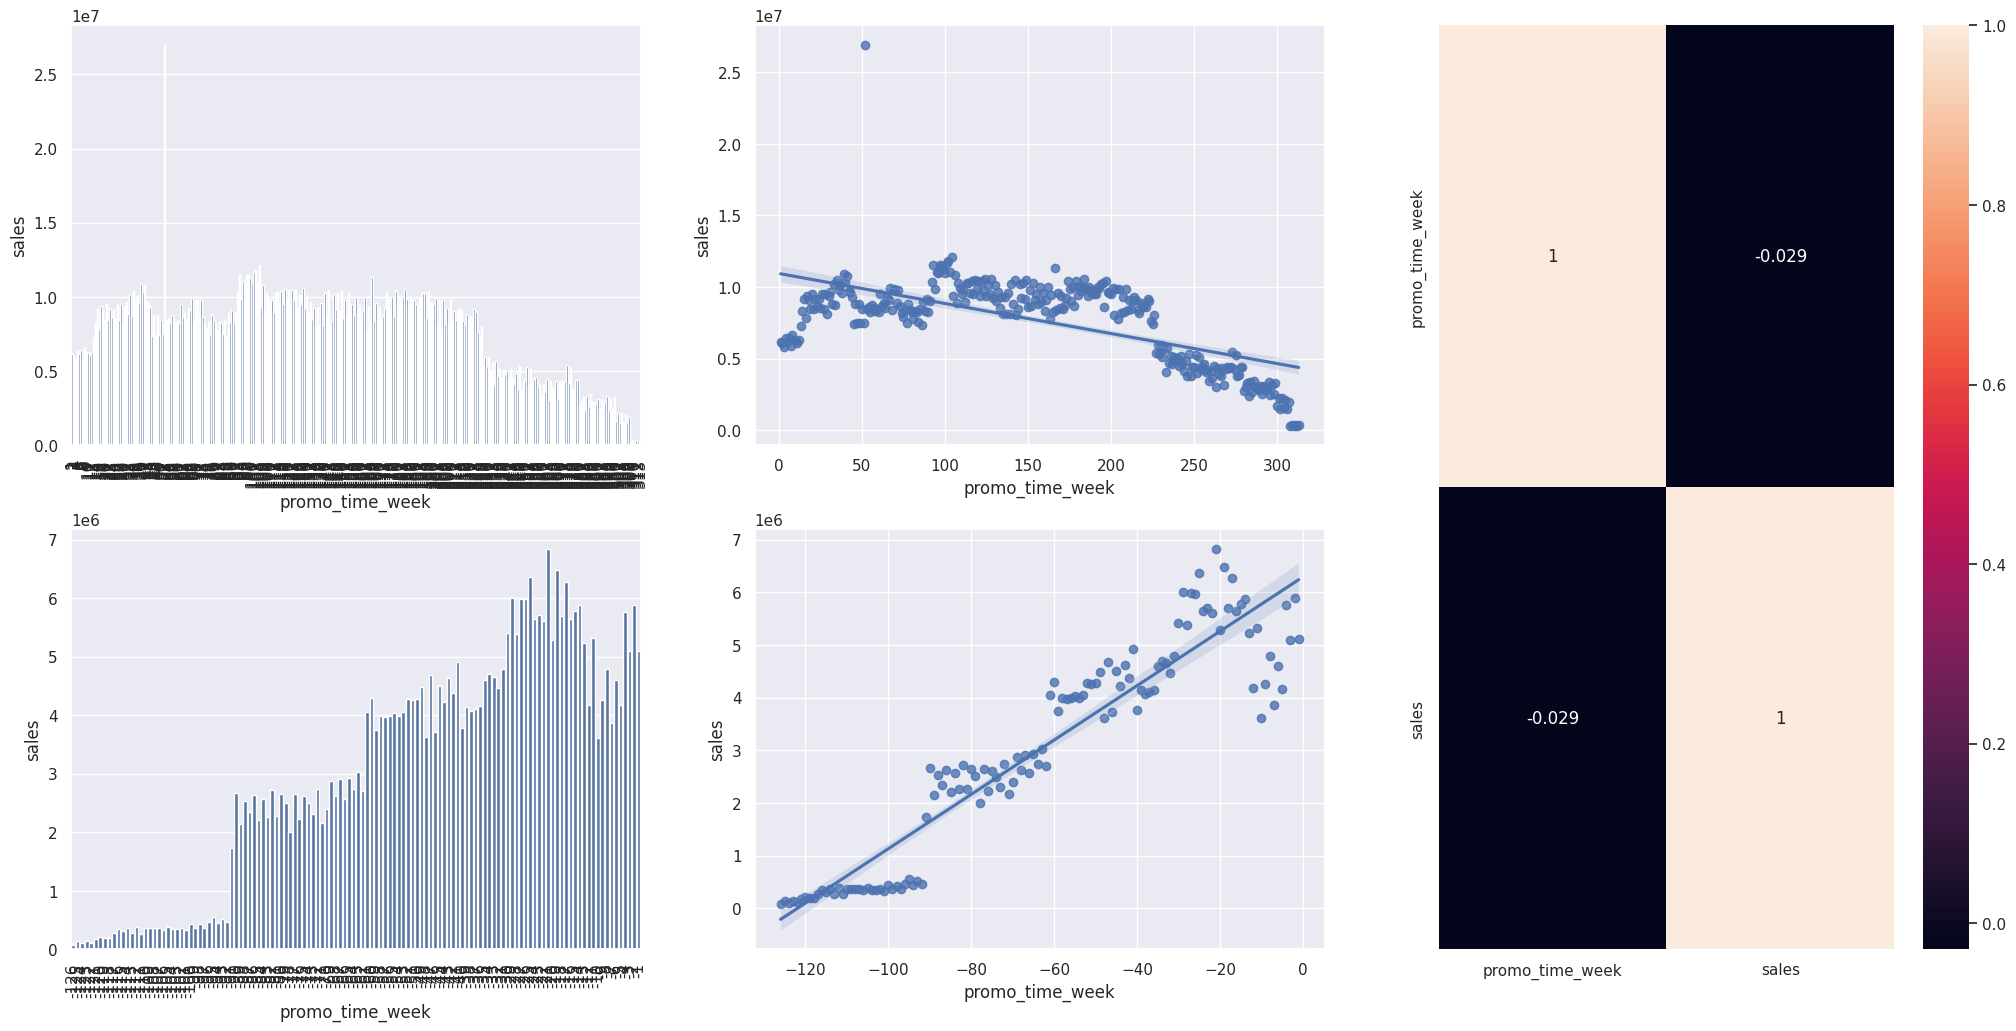

In [11]:
# Grouping data by promo_time_week and summing sales
aux1=df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Define GridSpec layout
grid=GridSpec(2,3)

# Subplot 1: Bar Plot for extended promo
plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week']>0]  # Filter for weeks with extended promo (promo_time_week > 0)
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

# Subplot 2: Regression Plot for extended promo
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

# Subplot 3: Bar Plot for regular promo
plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week']<0] # Filter for weeks with regular promo (promo_time_week < 0)
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90)

# Subplot 4: Regression Plot for regular promo
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# Subplot 5: Correlation Heatmap
plt.subplot(grid[:,2]) # Use entire column for heatmap
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### Abstract

The provided visualizations aim to analyze the relationship between the duration of promotional activity (`promo_time_week`) and store sales. The hypothesis tested is whether stores with promotions active for a longer time should sell more. The analysis uses bar plots, regression plots, and correlation heatmaps to explore this relationship. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Bar Plot for Extended Promo:
- The bar plot shows total sales by `promo_time_week` for weeks with extended promotions (positive `promo_time_week` values).
- Sales fluctuate without a clear upward trend as `promo_time_week` increases.
- This indicates that longer promotional activity does not necessarily correlate with higher sales for extended promotions.

#### Regression Plot for Extended Promo:
- The regression plot displays the relationship between `promo_time_week` and sales for extended promotions.
- The regression line is relatively flat, suggesting no significant positive correlation between the duration of extended promotions and sales.
- Some outliers and variability are observed, indicating other influencing factors.

#### Bar Plot for Regular Promo:
- The bar plot shows total sales by `promo_time_week` for weeks with regular promotions (negative `promo_time_week` values).
- Sales appear to increase with a higher negative `promo_time_week` (indicating earlier promotional activity).
- This suggests that sales are higher closer to the start of regular promotions.

#### Regression Plot for Regular Promo:
- The regression plot shows a positive relationship between `promo_time_week` and sales for regular promotions (higher sales closer to the start of the promotion).
- The positive trend indicates that regular promotions might be more effective initially.

#### Correlation Heatmap:
- The heatmap shows the Pearson correlation coefficients between `promo_time_week` and sales.
- The correlation coefficient is -0.029, indicating a very weak negative correlation.
- This supports that longer promotional activity does not lead to significantly higher sales overall.

### Conclusion

Based on the visualizations, the hypothesis that stores with promotions active for a longer time should sell more is not supported. The data shows no significant positive correlation between `promo_time_week` and sales. Other factors might be more influential in determining sales performance during promotional periods.


## H5 Stores with more promotion days should sell more. FALSE

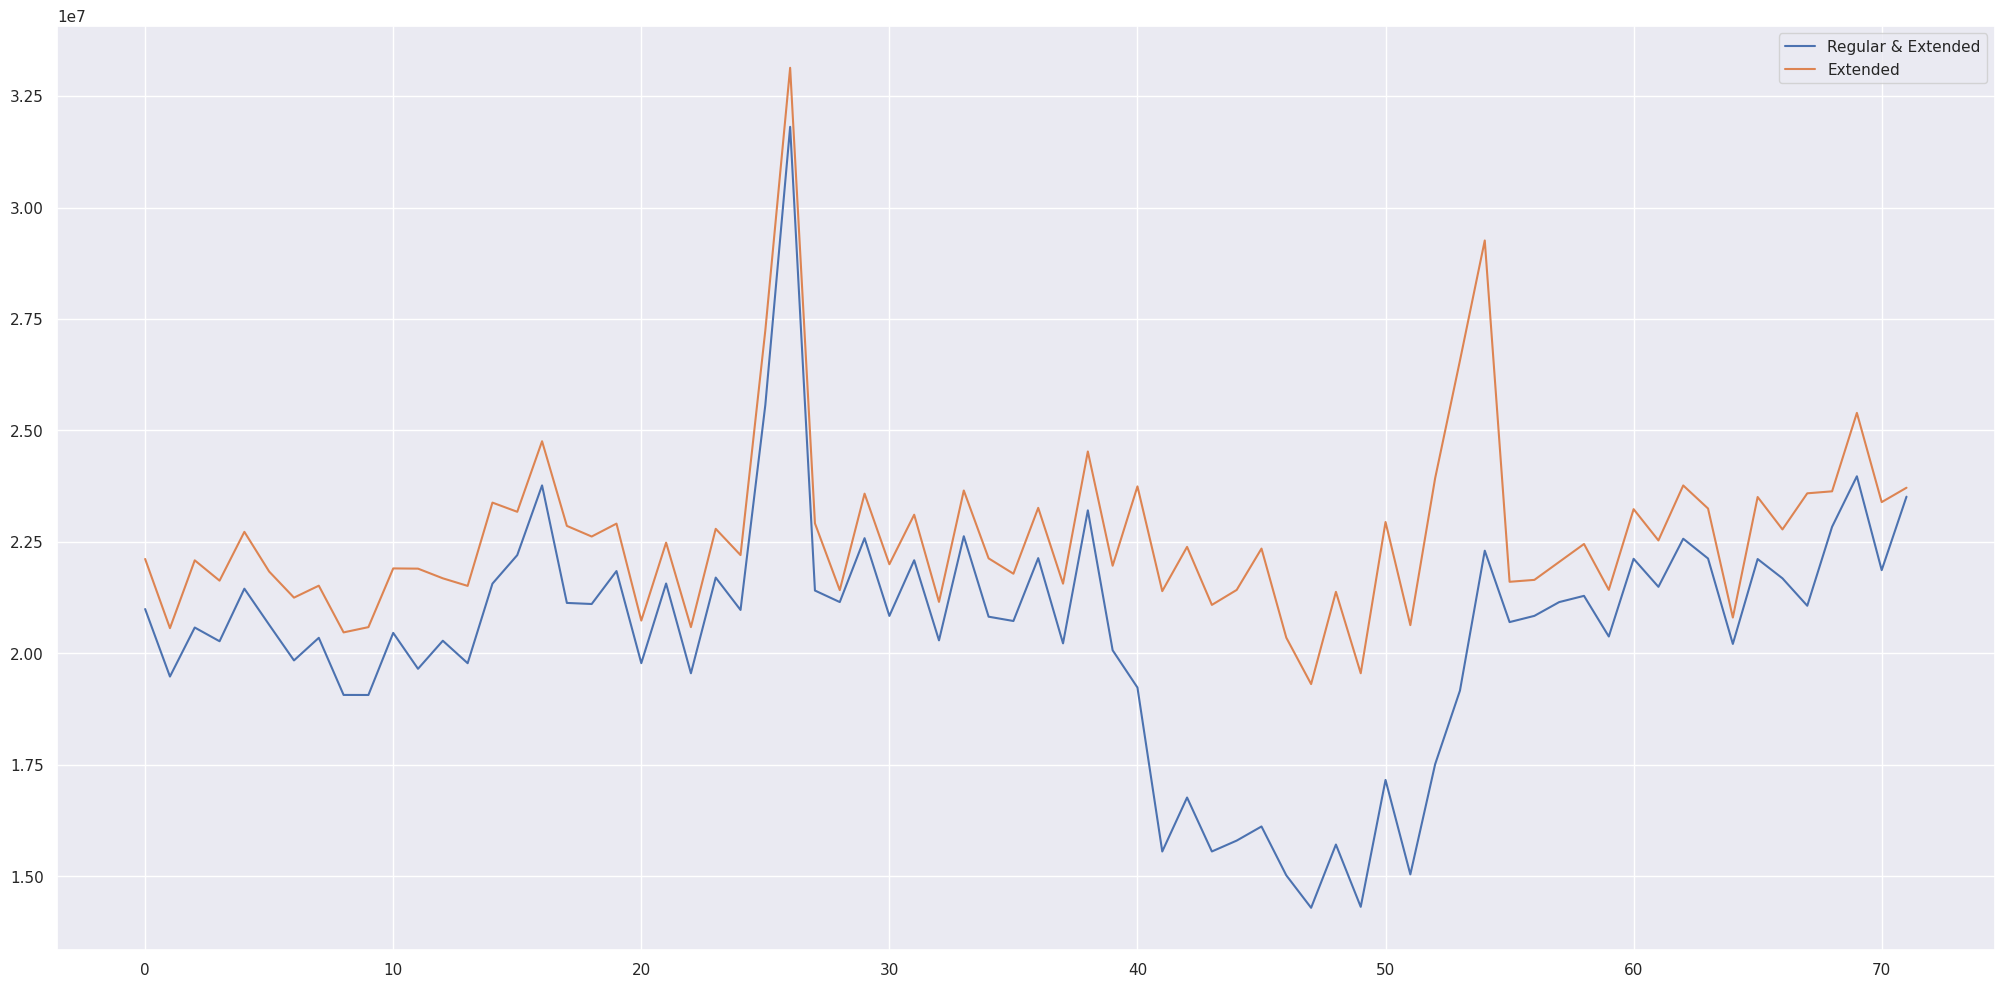

In [12]:
# Grouping data by 'promo' and 'promo2' and summing sales
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Filter data for weeks where both promotions are active
aux1=df4[(df4['promo']==1)&(df4[ 'promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Filter data for weeks where only the regular promo is active
# aux2 = df4[(df4['promo'] == 1) & (df4[['promo2']==0])][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Plotting the data
fig, ax = plt.subplots()
aux1.plot(ax=ax, label='Regular & Extended')
aux2.plot(ax=ax, label='Extended')

# Setting the legend
ax.legend(labels=['Regular & Extended', 'Extended'])
plt.show()

### Abstract

The provided analysis aims to determine if stores with more promotion days should sell more. The hypothesis tested is whether an increased number of promotional days leads to higher sales. The analysis uses line plots to compare sales during weeks with different promotional activities. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'promo' and 'promo2':

- The data is grouped by the 'promo' and 'promo2' columns, and sales are summed for each combination.

#### Line Plot for Sales During Different Promotional Periods:

- The line plot compares sales during weeks where both promotions (regular and extended) are active and weeks where only the extended promotion is active.
- The blue line represents weeks with both regular and extended promotions active.
- The orange line represents weeks with only the extended promotion active.

### Observations

#### Sales Trends for Regular & Extended Promotions:

- The sales fluctuate over the weeks with no consistent upward trend indicating higher sales for weeks with both promotions active.

#### Sales Trends for Extended Promotions:

- Similarly, the sales for weeks with only extended promotions also show fluctuations without a clear upward trend.

#### Comparison of Sales:

- Both lines show similar patterns of fluctuations, with occasional peaks and troughs.
- There is no consistent evidence to suggest that having more promotion days (both regular and extended) leads to significantly higher sales compared to having only the extended promotion.

### Conclusion

Based on the visualizations, the hypothesis that stores with more promotion days should sell more is not supported. The data shows no significant positive correlation between the number of promotional days and sales. Other factors might be more influential in determining sales performance during promotional periods.


## H6 Stores with more consecutive promotions should sell more.FALSE

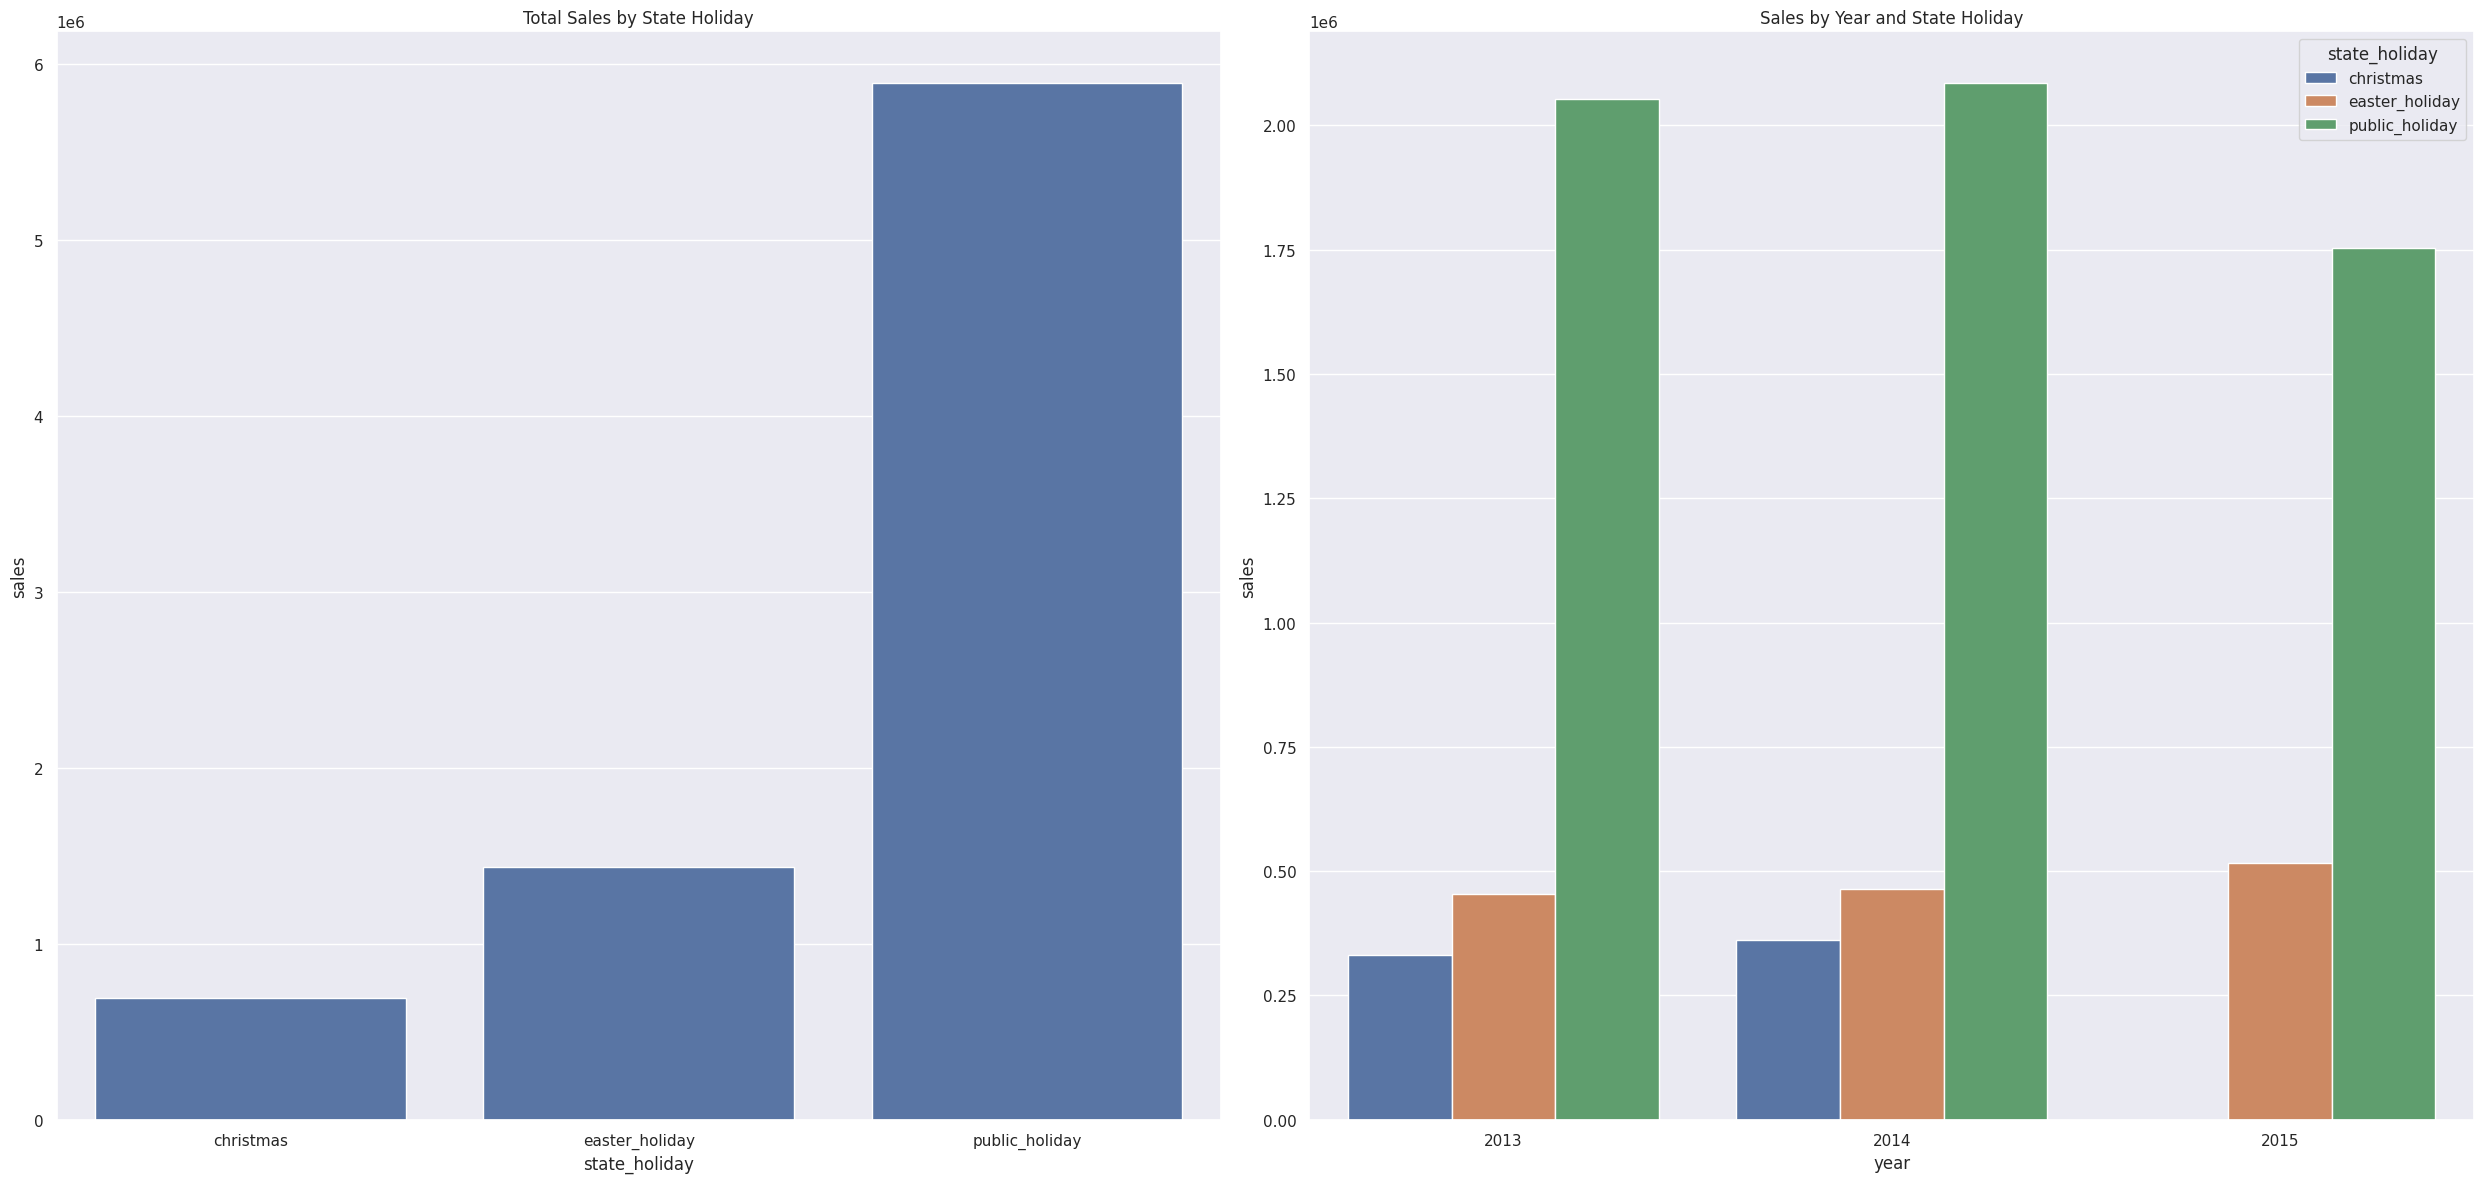

In [13]:
# Filtering data to exclude regular days
aux = df4[df4['state_holiday'] != 'regular_day']

# Subplot 1: Total Sales by State Holiday
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title('Total Sales by State Holiday')

# Subplot 2: Sales by Year and State Holiday
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.title('Sales by Year and State Holiday')

# Display the plots
plt.tight_layout()
plt.show()

### Abstract

The provided analysis aims to evaluate the impact of state holidays on store sales. The hypothesis tested is whether sales increase during state holidays compared to regular days. The analysis uses bar plots to visualize total sales during different types of state holidays and across different years. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'state_holiday':
- The data is filtered to exclude regular days, focusing only on state holidays.
- Sales are grouped by the 'state_holiday' column and summed for each type of holiday.

#### Bar Plot for Total Sales by State Holiday:
- The bar plot visualizes the total sales for each type of state holiday.
- This helps in understanding which holidays contribute more to sales.

#### Bar Plot for Sales by Year and State Holiday:
- The bar plot compares sales across different years, with a hue representing the type of state holiday.
- This provides insights into the sales trend during holidays over the years.

### Observations

#### Total Sales by State Holiday:
- Different state holidays show varying levels of total sales.
- Public holidays have the highest sales, followed by Easter holidays and Christmas.

#### Sales Trends by Year and State Holiday:
- Sales trends during holidays can be observed over multiple years.
- Public holidays consistently show higher sales across the years.
- Easter holidays also show significant sales, especially in 2013.
- Christmas shows the least sales impact among the holidays.

### Conclusion

The visualizations help in understanding the impact of state holidays on sales. The data shows that certain holidays, particularly public holidays, lead to higher sales, supporting the hypothesis that sales increase during state holidays compared to regular days. The analysis does not support the idea that consecutive promotions necessarily lead to higher sales; the impact varies depending on the type of holiday.


## H7 Stores should sell more over the years.

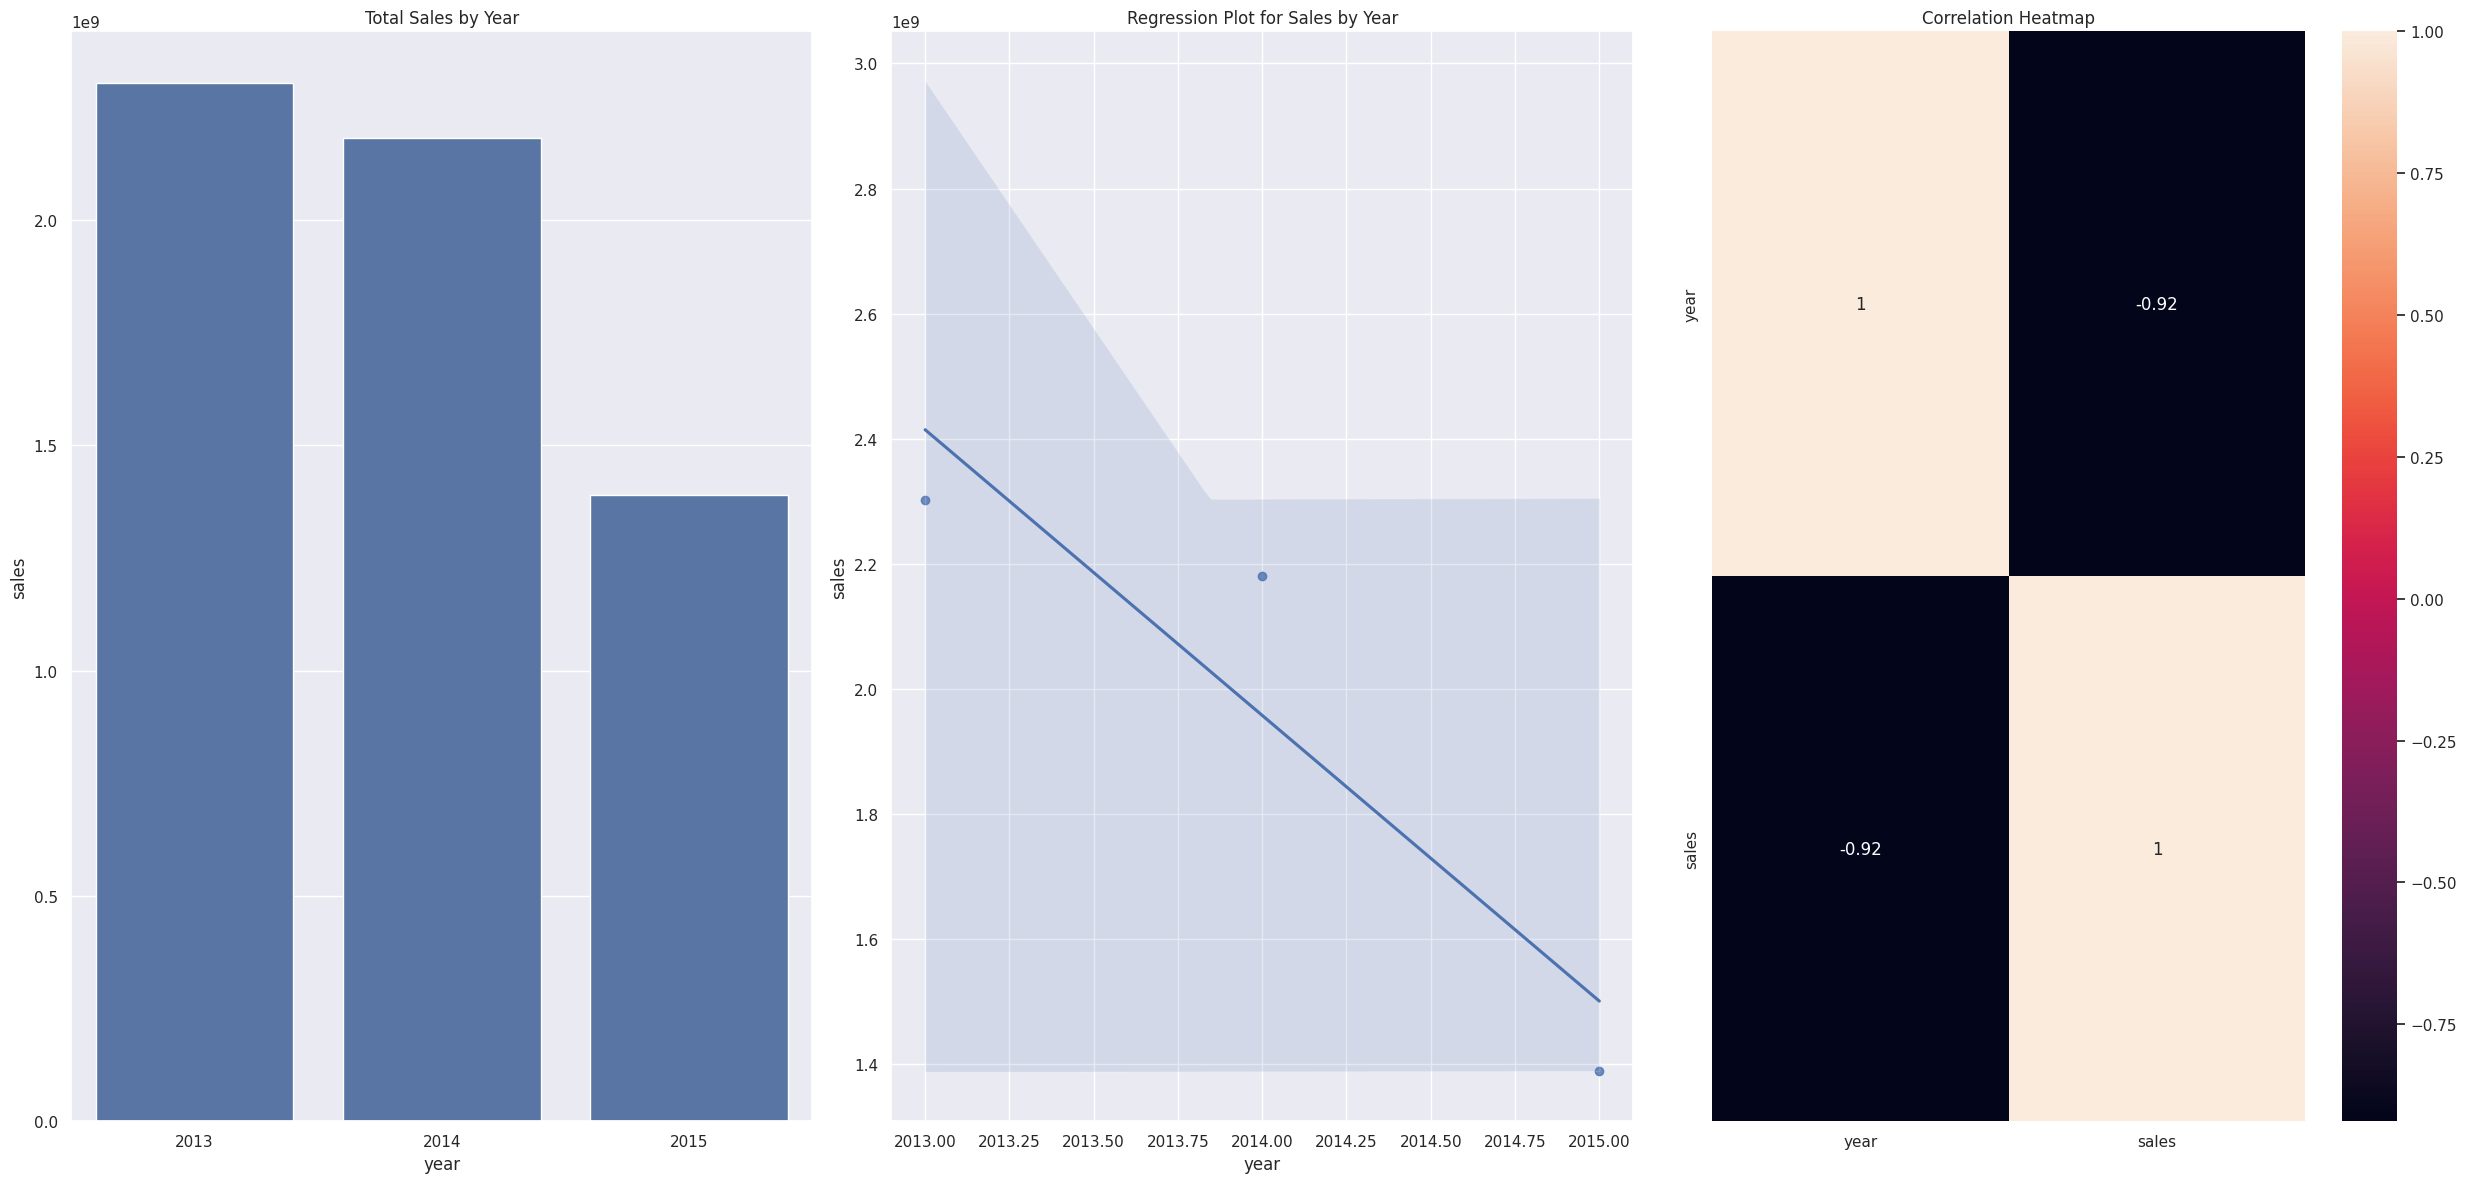

In [14]:
# Grouping data by 'year' and summing sales
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Subplot 1: Bar Plot for Total Sales by Year
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)
plt.title('Total Sales by Year')

# Subplot 2: Regression Plot for Sales by Year
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)
plt.title('Regression Plot for Sales by Year')

# Subplot 3: Correlation Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap')

# Display the plots
plt.tight_layout()


### Abstract

The provided analysis aims to evaluate the trend in store sales over the years. The hypothesis tested is whether store sales should increase consistently over the years. The analysis uses bar plots, regression plots, and correlation heatmaps to explore this relationship. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'year':
- The data is grouped by the 'year' column, and sales are summed for each year.

#### Bar Plot for Total Sales by Year:
- The bar plot visualizes the total sales for each year.
- This helps in understanding the annual sales trend over the years.

#### Regression Plot for Sales by Year:
- The regression plot displays the relationship between the year and total sales.
- This helps in identifying any trend in sales over the years.

#### Correlation Heatmap:
- The heatmap shows the Pearson correlation coefficient between the year and total sales.
- This provides a quantitative measure of the relationship between the two variables.

### Observations

#### Total Sales by Year:
- The bar plot indicates the total sales for each year, showing how sales have changed annually.
- There is a noticeable decline in sales from 2013 to 2015.

#### Sales Trends by Year:
- The regression plot shows a downward trend in sales over the years.
- This suggests that sales have decreased rather than increased over the observed period.

#### Correlation Between Year and Sales:
- The heatmap shows a strong negative correlation (-0.92) between the year and total sales.
- This indicates that as the years progress, sales have tended to decrease.

### Conclusion

Based on the visualizations, the hypothesis that stores should sell more over the years is not supported. The data shows a declining trend in sales from 2013 to 2015. This analysis highlights the need for further investigation into the factors contributing to the decrease in sales over the years.


## H8 Stores should sell more in the second half of the year. FALSE

Text(0.5, 1.0, 'Correlation Heatmap')

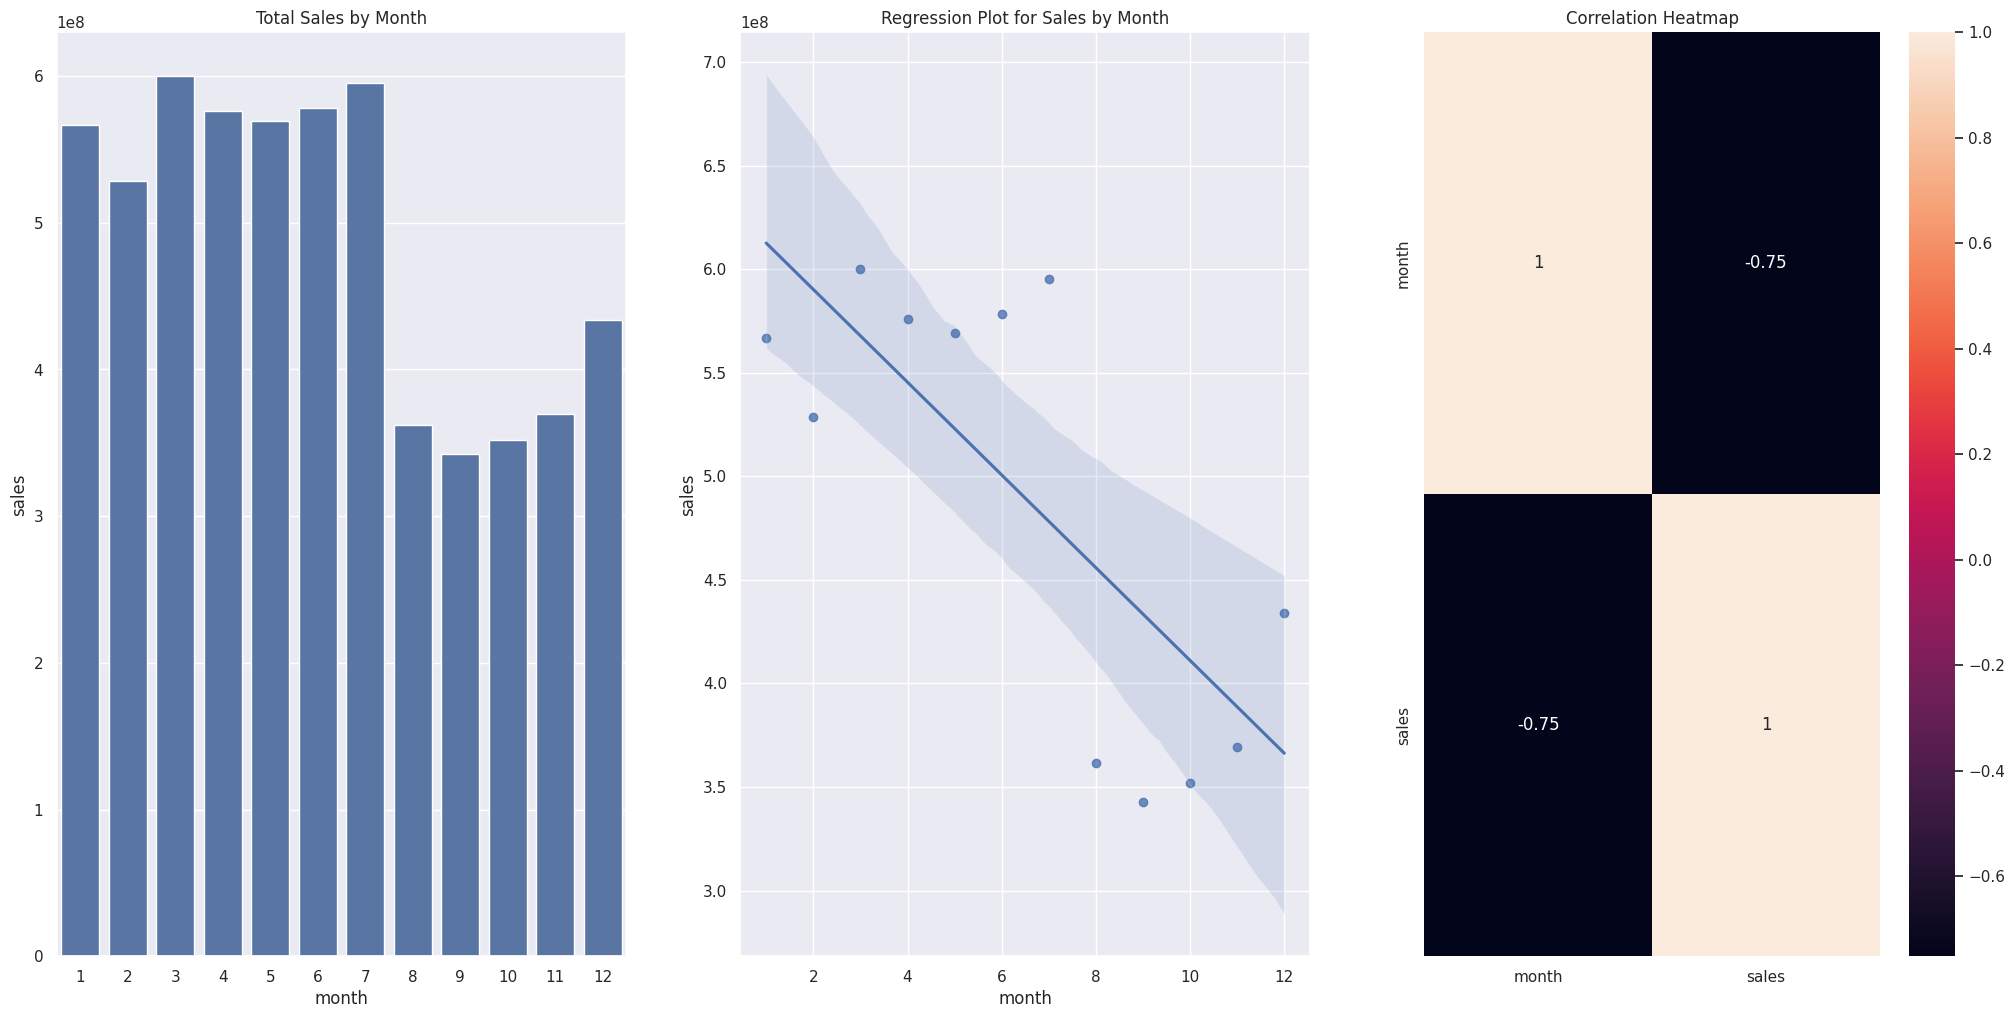

In [15]:
# Grouping data by 'month' and summing sales
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Subplot 1: Bar Plot for Total Sales by Month
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)
plt.title('Total Sales by Month')

# Subplot 2: Regression Plot for Sales by Month
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
plt.title('Regression Plot for Sales by Month')

# Subplot 3: Correlation Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap')


### Abstract

The provided analysis aims to evaluate the trend in store sales over different months. The hypothesis tested is whether store sales should increase in the second half of the year compared to the first half. The analysis uses bar plots, regression plots, and correlation heatmaps to explore this relationship. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'month':
- The data is grouped by the 'month' column, and sales are summed for each month.

#### Bar Plot for Total Sales by Month:
- The bar plot visualizes the total sales for each month.
- This helps in understanding the monthly sales trend over the year.

#### Regression Plot for Sales by Month:
- The regression plot displays the relationship between the month and total sales.
- This helps in identifying any trend in sales over the months.

#### Correlation Heatmap:
- The heatmap shows the Pearson correlation coefficient between the month and total sales.
- This provides a quantitative measure of the relationship between the two variables.

### Observations

#### Total Sales by Month:
- The bar plot indicates the total sales for each month, showing how sales have changed monthly.
- Sales tend to be higher in the first half of the year (especially from January to July) compared to the second half.

#### Sales Trends by Month:
- The regression plot shows a downward trend in sales as the months progress from January to December.
- This suggests that sales decrease over the months, contrary to the hypothesis.

#### Correlation Between Month and Sales:
- The heatmap shows a strong negative correlation (-0.75) between the month and total sales.
- This indicates that as the months progress, sales have tended to decrease.

### Conclusion

Based on the visualizations, the hypothesis that stores should sell more in the second half of the year is not supported. The data shows a declining trend in sales from the first half to the second half of the year. This analysis highlights the need for further investigation into the factors contributing to the decrease in sales over the months.


## H9 Stores should sell more after the 10th of each month. TRUE

Text(0.5, 1.0, 'Sales Before and After 10 Days')

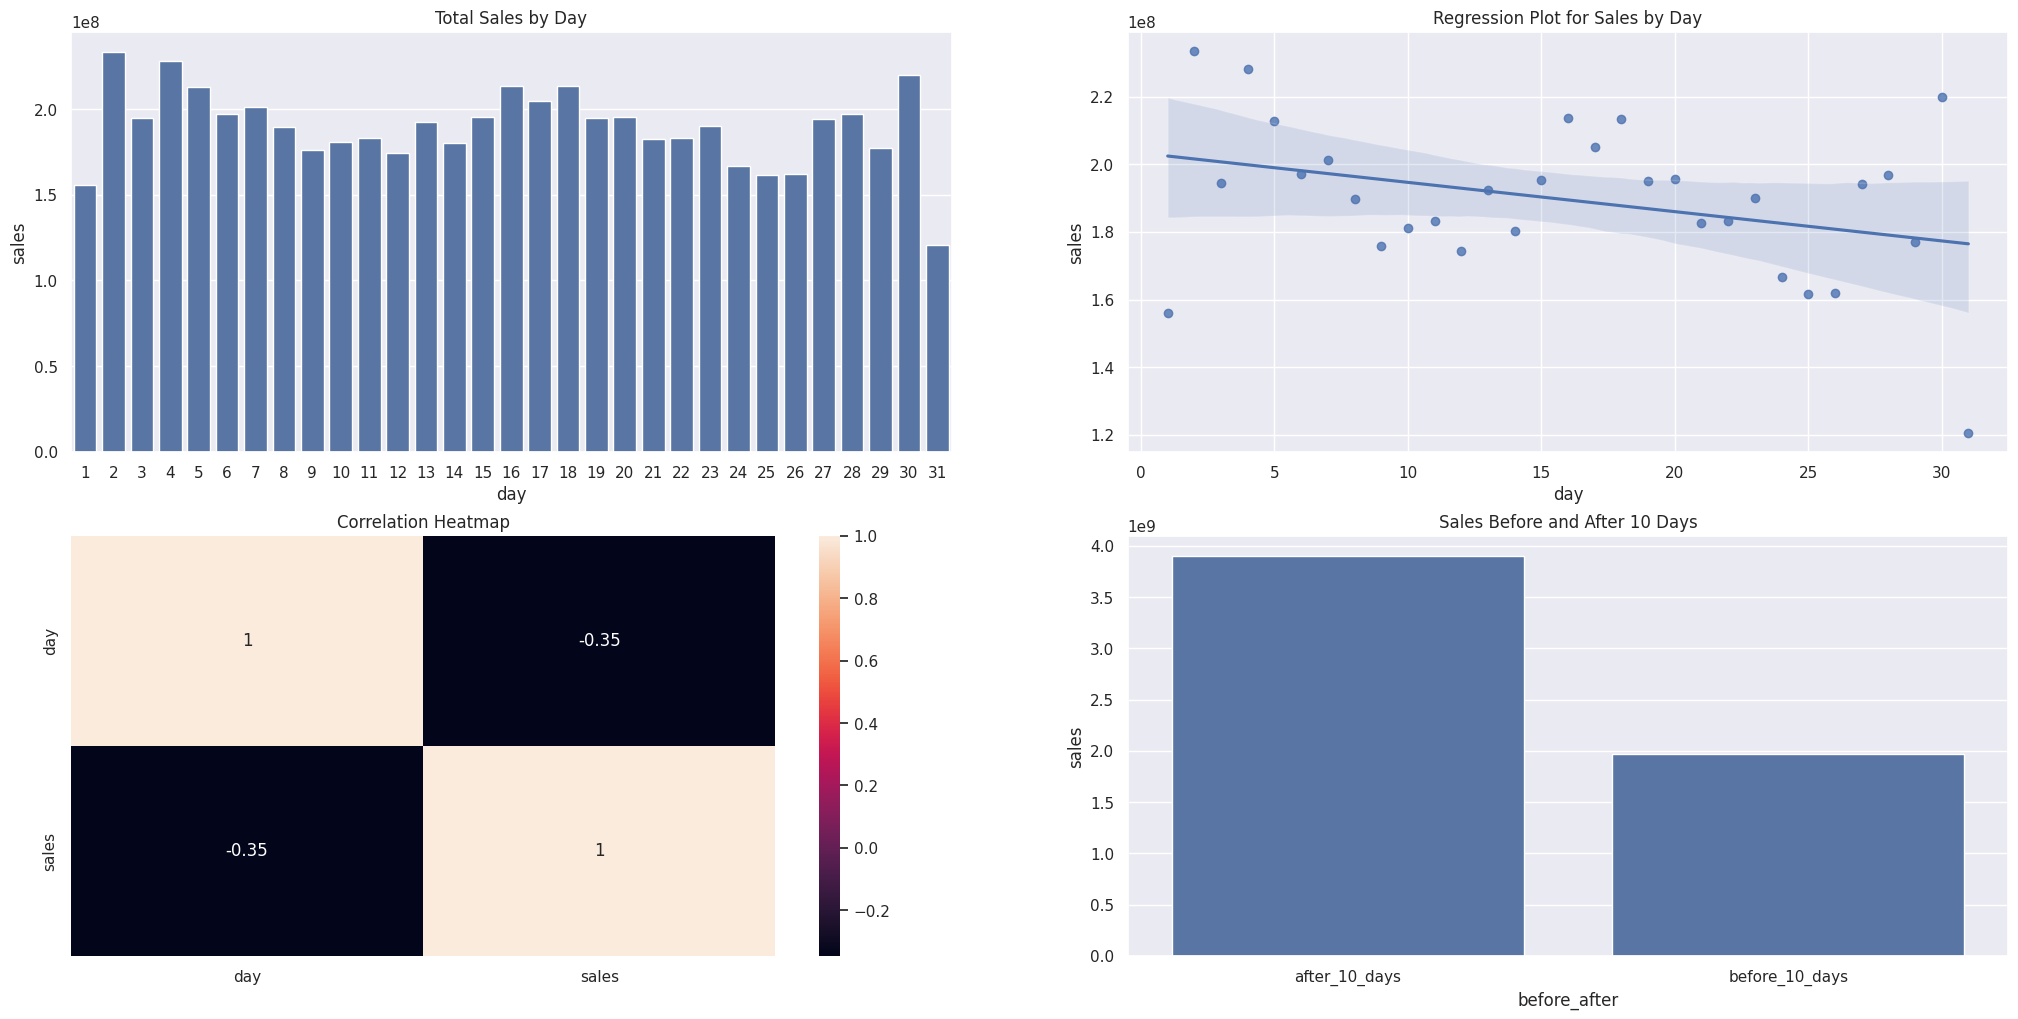

In [16]:
# Grouping data by 'day' and summing sales
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Subplot 1: Bar Plot for Total Sales by Day
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Total Sales by Day')

# Subplot 2: Regression Plot for Sales by Day
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)
plt.title('Regression Plot for Sales by Day')

# Subplot 3: Correlation Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap')

# Categorizing days into 'before 10 days' and 'after 10 days'
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# Grouping data by 'before_after' and summing sales
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Subplot 4: Bar Plot for Sales Before and After 10 Days
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.title('Sales Before and After 10 Days')

### Abstract

The provided analysis aims to evaluate the trend in store sales over different days of the month. The hypothesis tested is whether store sales should increase after the 10th of each month compared to the first 10 days. The analysis uses bar plots, regression plots, and correlation heatmaps to explore this relationship. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'day':
- The data is grouped by the 'day' column, and sales are summed for each day.

#### Bar Plot for Total Sales by Day:
- The bar plot visualizes the total sales for each day of the month.
- This helps in understanding the daily sales trend within a month.

#### Regression Plot for Sales by Day:
- The regression plot displays the relationship between the day and total sales.
- This helps in identifying any trend in sales over the days of the month.

#### Correlation Heatmap:
- The heatmap shows the Pearson correlation coefficient between the day and total sales.
- This provides a quantitative measure of the relationship between the two variables.

#### Bar Plot for Sales Before and After 10 Days:
- Days are categorized into 'before 10 days' and 'after 10 days' based on the day value.
- The bar plot compares the total sales for these two categories.

### Observations

#### Total Sales by Day:
- The bar plot indicates the total sales for each day of the month, showing how sales have changed daily.
- Some days exhibit higher sales compared to others, particularly at the beginning and end of the month.

#### Sales Trends by Day:
- The regression plot shows a slight downward trend in sales as the days progress from the 1st to the 31st.
- This suggests that sales tend to decrease slightly over the days of the month.

#### Correlation Between Day and Sales:
- The heatmap shows a negative correlation (-0.35) between the day and total sales.
- This indicates that as the days progress, sales tend to decrease.

#### Sales Before and After 10 Days:
- The bar plot shows the total sales before and after the first 10 days of the month.
- Sales are higher after the 10th of each month compared to before the 10th.

### Conclusion

Based on the visualizations, the hypothesis that stores should sell more after the 10th of each month is supported. The data shows higher sales in the latter part of the month compared to the first 10 days. This analysis highlights the potential for increased sales activity in the latter part of the month.


## H10 Stores should sell less on weekends. TRUE


Text(0.5, 1.0, 'Correlation Heatmap')

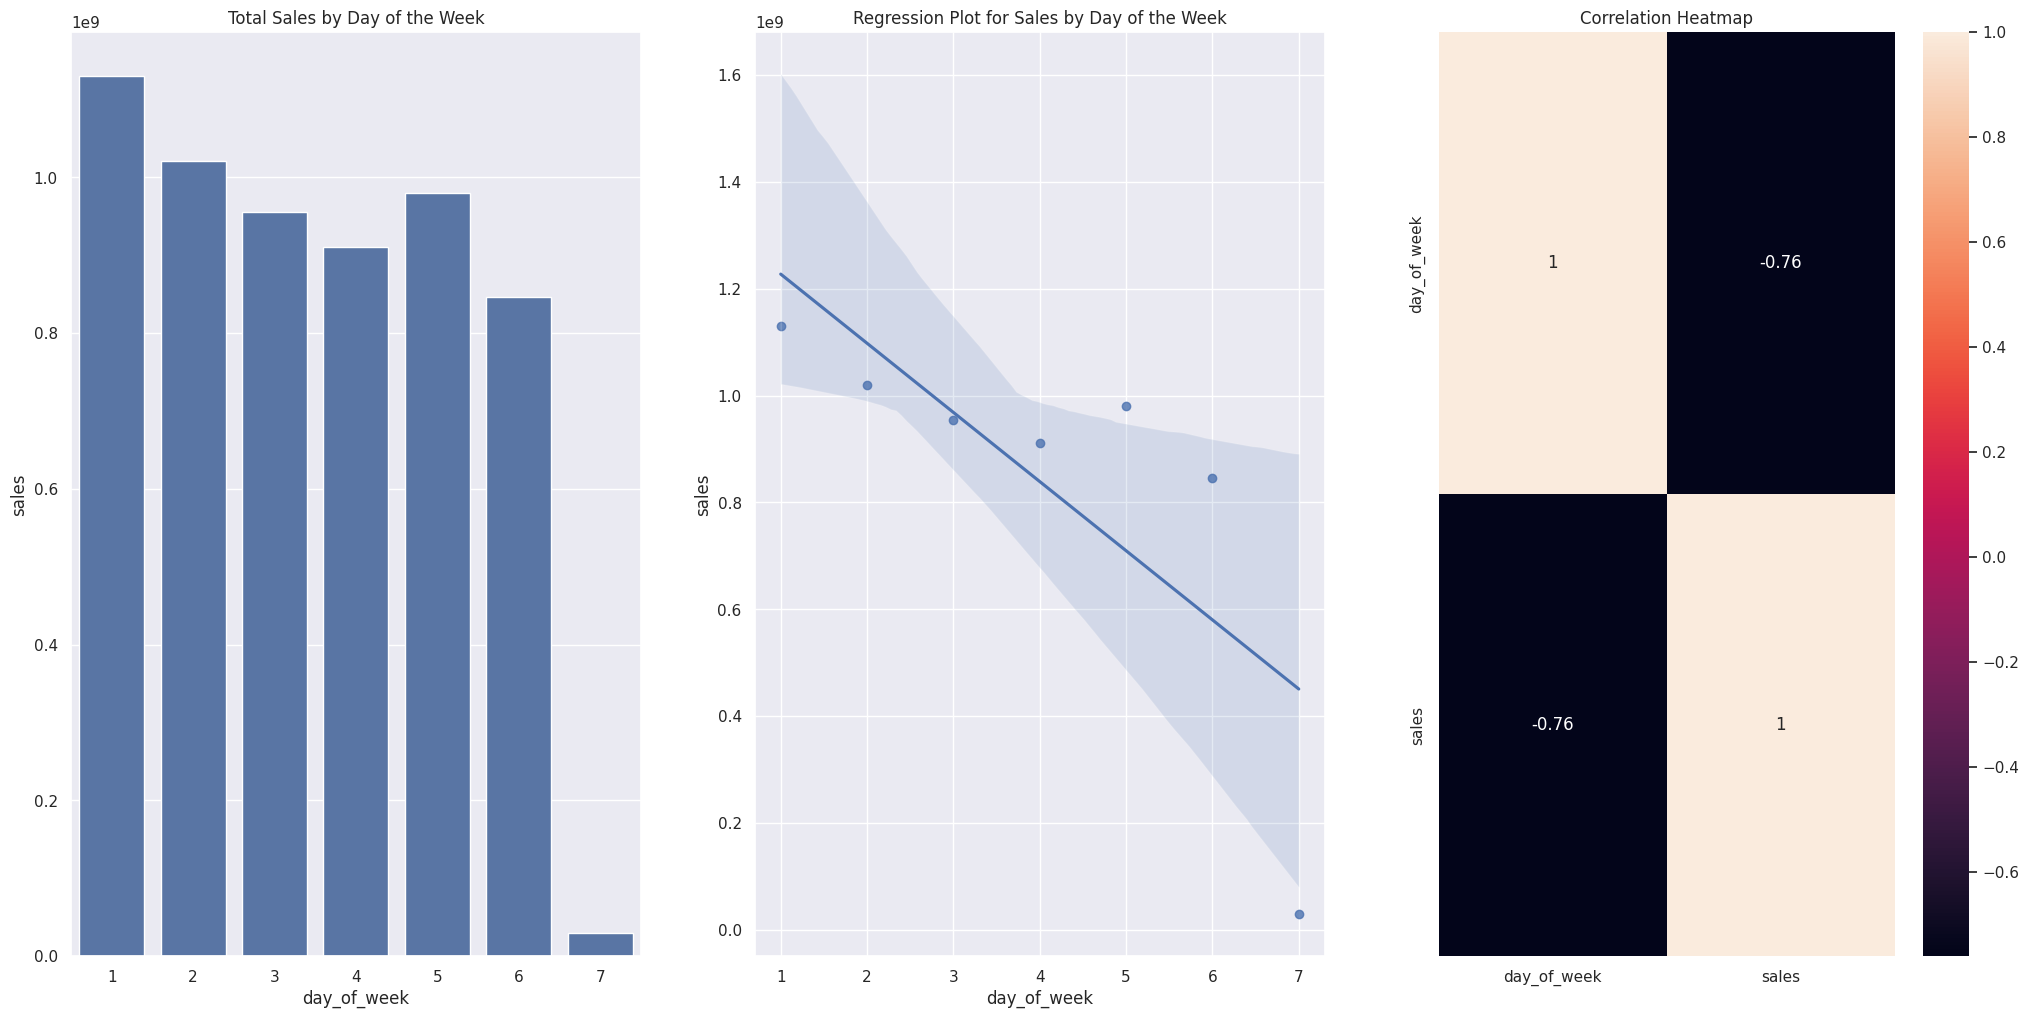

In [17]:
# Create 'day_of_week' column from 'date' column
df4['day_of_week'] = df4['date'].dt.dayofweek + 1  # Monday=0, Sunday=6. Adding 1 makes Monday=1, Sunday=7.

# Grouping data by 'day_of_week' and summing sales
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Subplot 1: Bar Plot for Total Sales by Day of the Week
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.title('Total Sales by Day of the Week')

# Subplot 2: Regression Plot for Sales by Day of the Week
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.title('Regression Plot for Sales by Day of the Week')

# Subplot 3: Correlation Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap')

### Abstract

The provided analysis aims to evaluate the trend in store sales over different days of the week. The hypothesis tested is whether store sales should decrease on weekends compared to weekdays. The analysis uses bar plots, regression plots, and correlation heatmaps to explore this relationship. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'day_of_week':
- The data is grouped by the 'day_of_week' column, and sales are summed for each day.

#### Bar Plot for Total Sales by Day of the Week:
- The bar plot visualizes the total sales for each day of the week.
- This helps in understanding the weekly sales trend.

#### Regression Plot for Sales by Day of the Week:
- The regression plot displays the relationship between the day of the week and total sales.
- This helps in identifying any trend in sales over the days of the week.

#### Correlation Heatmap:
- The heatmap shows the Pearson correlation coefficient between the day of the week and total sales.
- This provides a quantitative measure of the relationship between the two variables.

### Observations

#### Total Sales by Day of the Week:
- The bar plot indicates the total sales for each day of the week, showing how sales have changed daily.
- Sales are noticeably lower on weekends, particularly on Sundays.

#### Sales Trends by Day of the Week:
- The regression plot shows a downward trend in sales from Monday to Sunday.
- This suggests that sales decrease as the week progresses, with the lowest sales on Sunday.

#### Correlation Between Day of the Week and Sales:
- The heatmap shows a strong negative correlation (-0.76) between the day of the week and total sales.
- This indicates that as the days progress from Monday to Sunday, sales tend to decrease.

### Conclusion

Based on the visualizations, the hypothesis that stores should sell less on weekends is supported. The data shows lower sales on weekends, particularly on Sundays, compared to weekdays. This analysis highlights the potential for decreased sales activity on weekends and can inform strategies to boost weekend sales.


## H11 Stores should sell less during school holidays. True

Text(0.5, 1.0, 'Sales by Month and School Holiday')

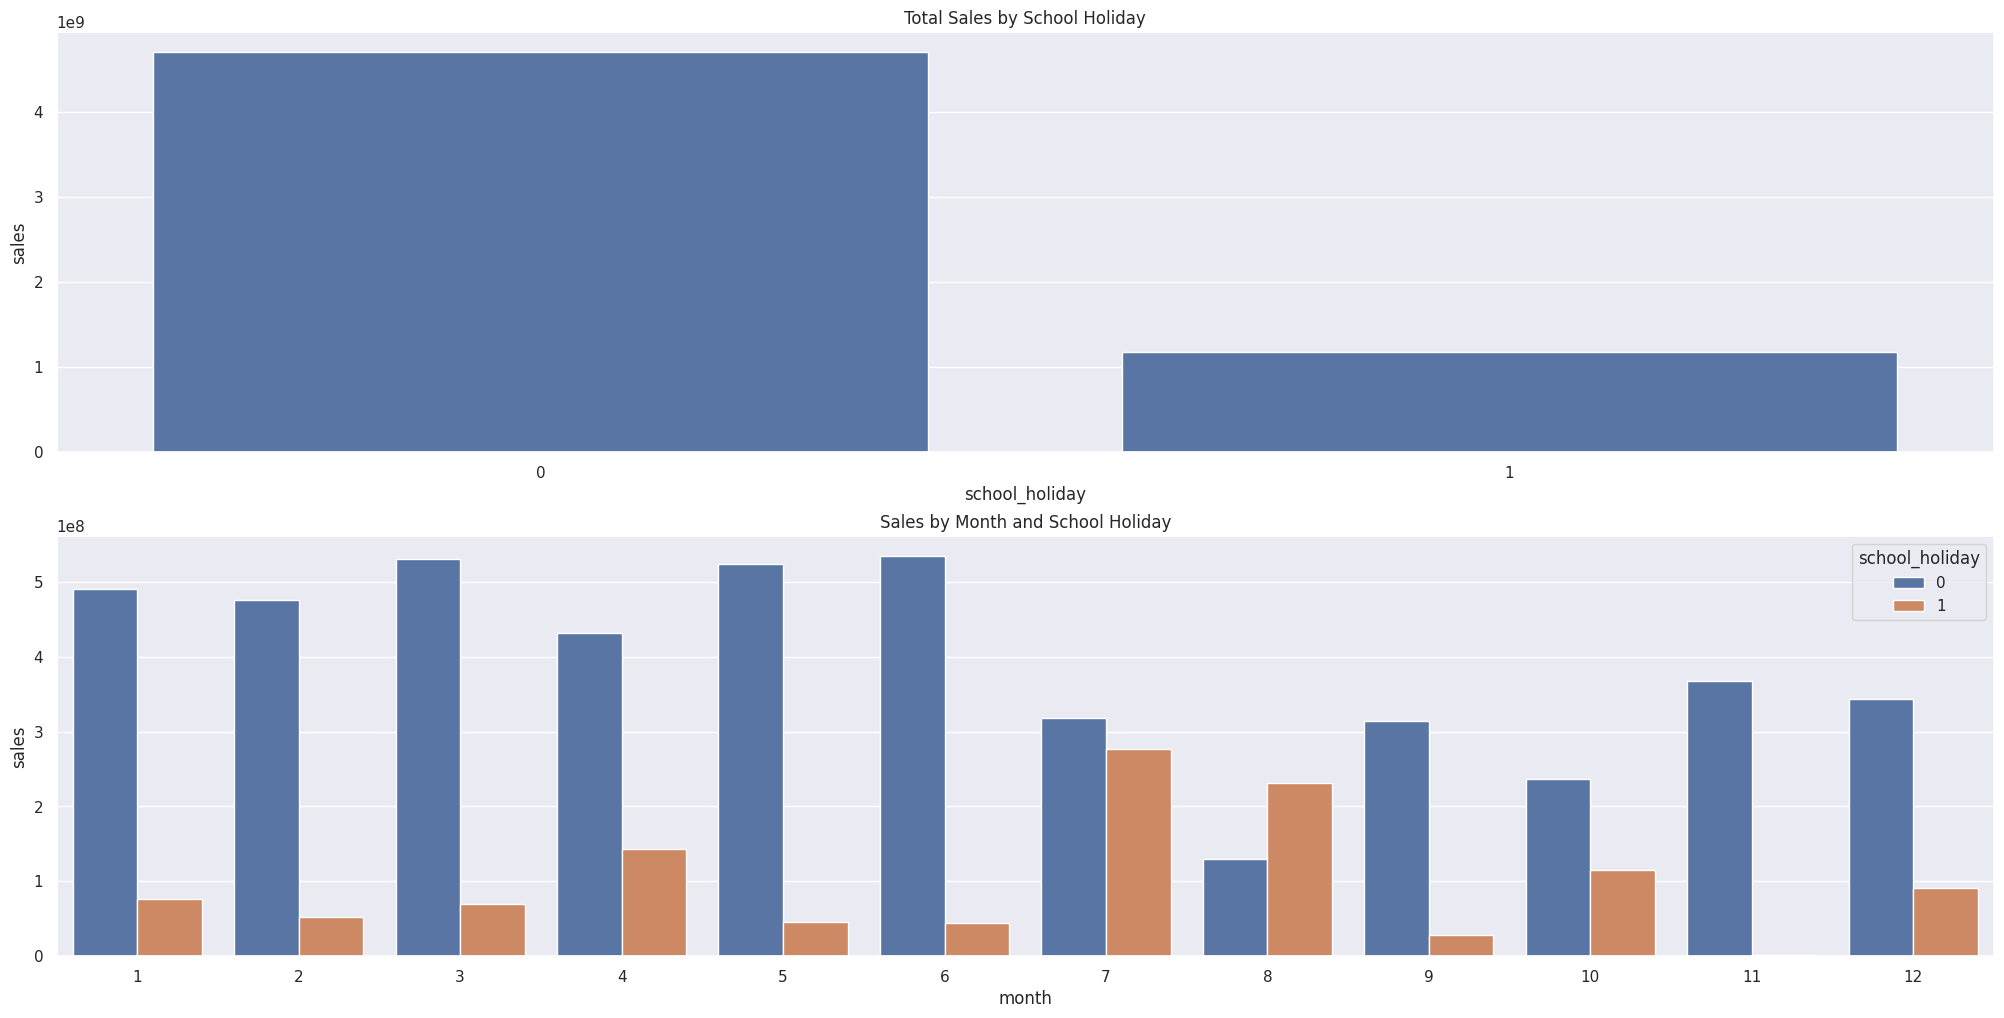

In [18]:
# Grouping data by 'school_holiday' and summing sales
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Grouping data by 'month' and 'school_holiday' and summing sales
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Subplot 1: Bar Plot for Total Sales by School Holiday
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title('Total Sales by School Holiday')

# Subplot 2: Bar Plot for Sales by Month and School Holiday
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title('Sales by Month and School Holiday')


### Abstract

The provided analysis aims to evaluate the impact of school holidays on store sales. The hypothesis tested is whether store sales should decrease during school holidays compared to non-holiday periods. The analysis uses bar plots to visualize total sales during school holidays and across different months. Below is the interpretation based on the visualizations.

### Interpretation of Visualizations

#### Grouping Data by 'school_holiday':
- The data is grouped by the 'school_holiday' column, and sales are summed for each category.

#### Grouping Data by 'month' and 'school_holiday':
- The data is grouped by the 'month' and 'school_holiday' columns, and sales are summed for each combination.

#### Bar Plot for Total Sales by School Holiday:
- The bar plot visualizes the total sales for periods with and without school holidays.
- This helps in understanding the overall impact of school holidays on sales.

#### Bar Plot for Sales by Month and School Holiday:
- The bar plot compares sales across different months, with a hue representing the presence of school holidays.
- This provides insights into the monthly sales trend during school holidays.

### Observations

#### Total Sales by School Holiday:
- The bar plot indicates the total sales for periods with and without school holidays.
- It shows significantly lower sales during school holidays compared to non-holiday periods.

#### Sales by Month and School Holiday:
- The bar plot shows the total sales for each month, differentiating between periods with and without school holidays.
- It helps identify any patterns or trends in sales across different months and holidays.
- Sales during school holidays are consistently lower across most months.

### Conclusion

Based on the visualizations, the hypothesis that stores should sell less during school holidays is supported. The data shows lower sales during school holidays compared to non-holiday periods. This analysis highlights the potential impact of school holidays on sales performance and can inform strategies to mitigate the effects of lower sales during these periods.


# Hipotheses summary

In [19]:
from tabulate import tabulate

tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H7', 'False', 'Low'],
       ['H8', 'False', 'Medium'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'High'],
       ['H13', 'True', 'Low']]

print(tabulate(tab, headers='firstrow'))


Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H7            False         Low
H8            False         Medium
H9            False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


# multivariable analysis

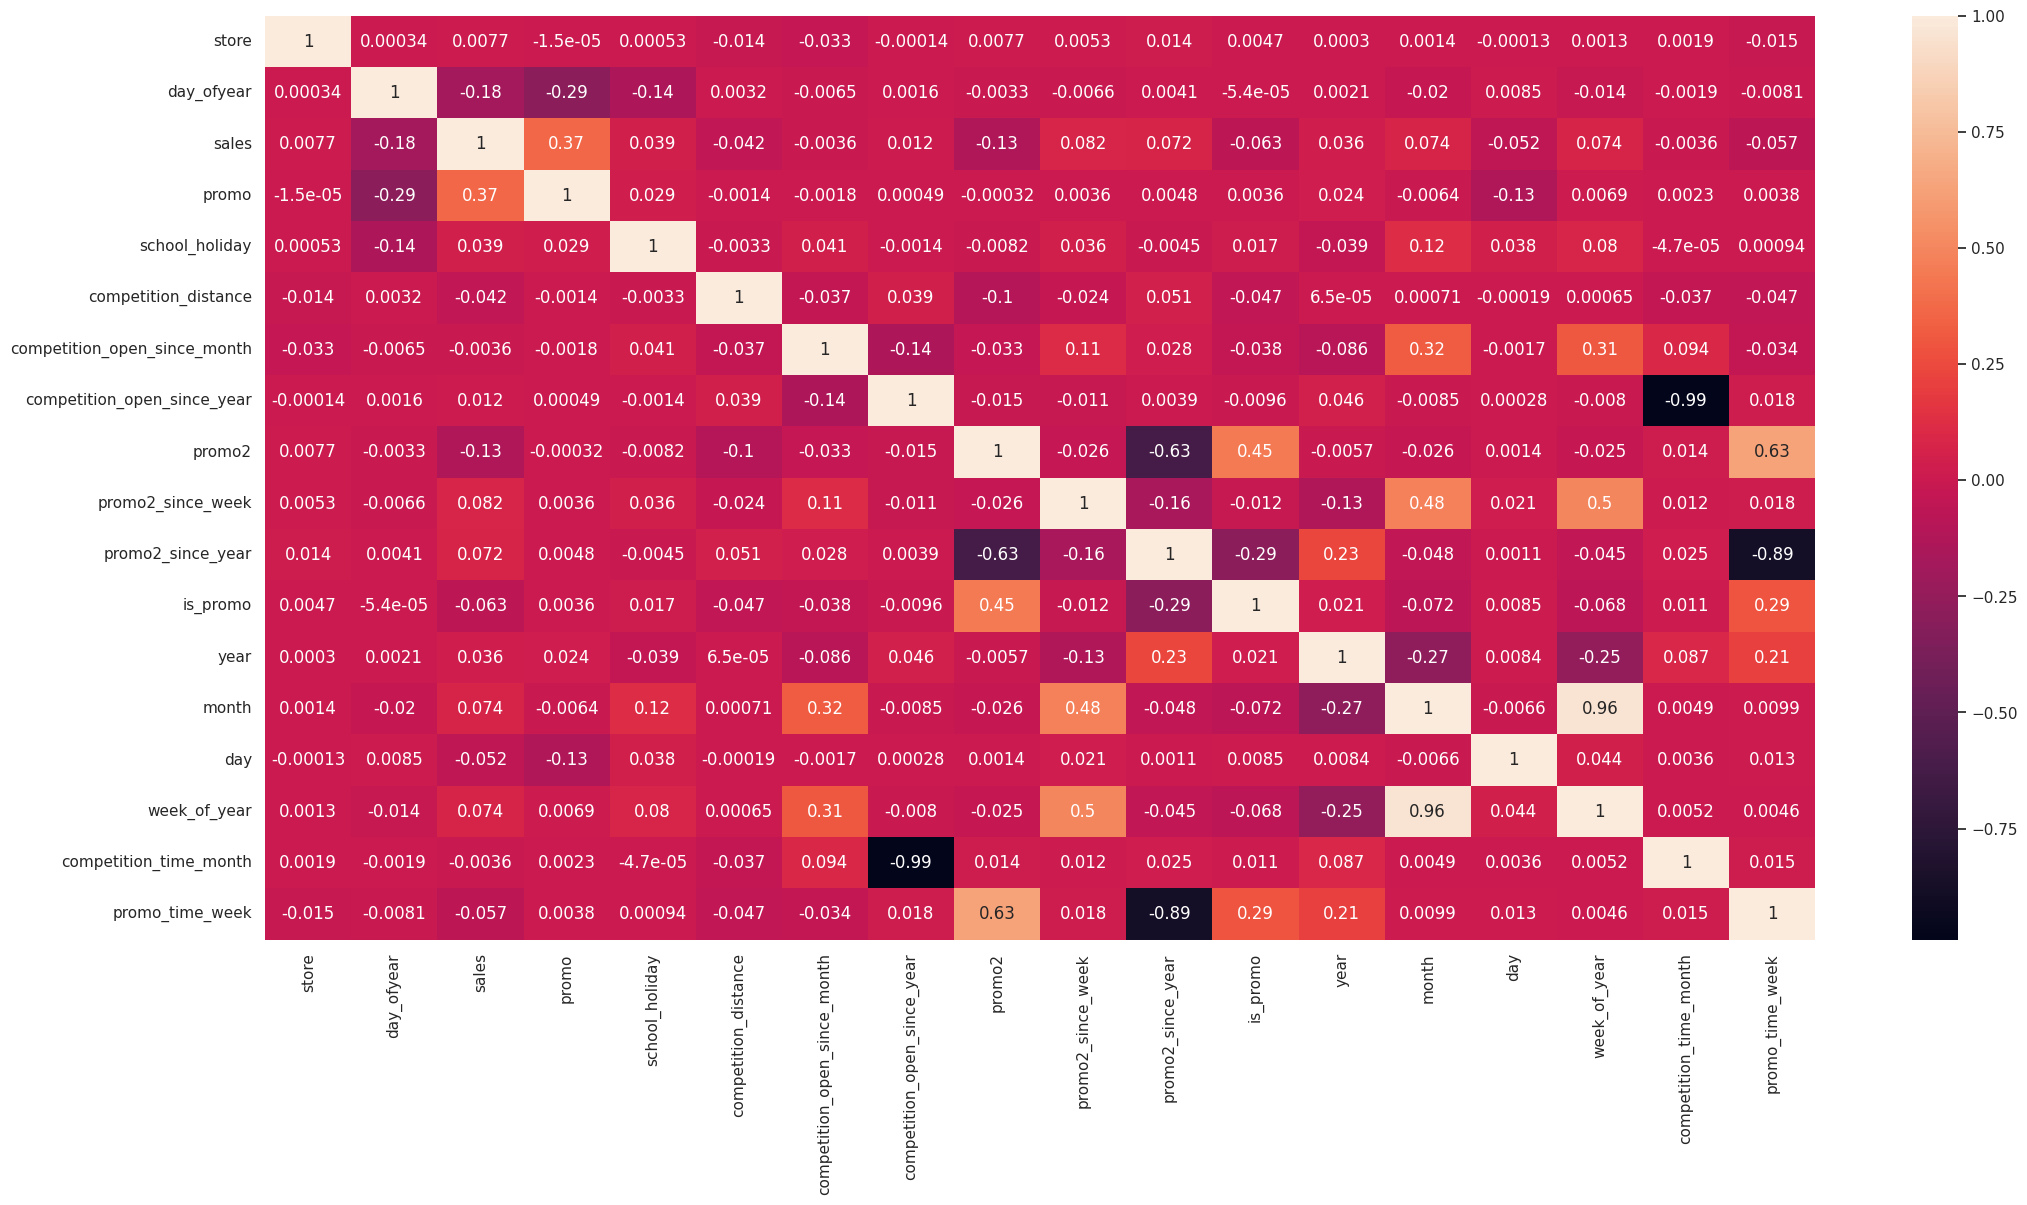

In [20]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# Categorical Attributes

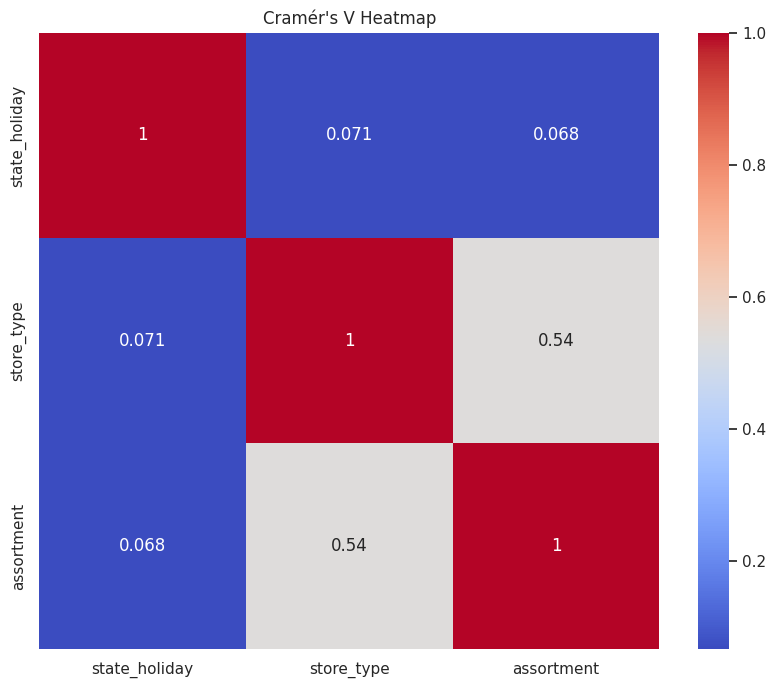

In [21]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x, y)
#     chi2 = chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))



# Select only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramér's V
a1 = cramers_v(a['state_holiday'], a['state_holiday'])
a2 = cramers_v(a['state_holiday'], a['store_type'])
a3 = cramers_v(a['state_holiday'], a['assortment'])
a4 = cramers_v(a['store_type'], a['state_holiday'])
a5 = cramers_v(a['store_type'], a['store_type'])
a6 = cramers_v(a['store_type'], a['assortment'])
a7 = cramers_v(a['assortment'], a['state_holiday'])
a8 = cramers_v(a['assortment'], a['store_type'])
a9 = cramers_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
                })
d.index = ['state_holiday', 'store_type', 'assortment']

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(d, annot=True, cmap='coolwarm')
plt.title('Cramér\'s V Heatmap')
plt.show()

## Interpretation of Cramér's V Heatmap

### Cramér's V Value Explanation:
- **Cramér's V** ranges from 0 to 1.
  - A value of **0** indicates no association between the variables.
  - A value of **1** indicates a perfect association.
  - Values between **0 and 1** indicate varying degrees of association.

### Observations

#### State Holiday vs. Other Variables:
- **State Holiday vs. State Holiday (a1)**:
  - The Cramér's V value is **1**, indicating a perfect association since it's the same variable.
- **State Holiday vs. Store Type (a2)**:
  - The Cramér's V value is **0.071**, indicating a very weak association between state holidays and store types.
- **State Holiday vs. Assortment (a3)**:
  - The Cramér's V value is **0.068**, indicating a very weak association between state holidays and assortment types.

#### Store Type vs. Other Variables:
- **Store Type vs. State Holiday (a4)**:
  - The Cramér's V value is **0.071**, which again shows a very weak association.
- **Store Type vs. Store Type (a5)**:
  - The Cramér's V value is **1**, indicating a perfect association since it's the same variable.
- **Store Type vs. Assortment (a6)**:
  - The Cramér's V value is **0.54**, indicating a moderate association between store types and assortment types.

#### Assortment vs. Other Variables:
- **Assortment vs. State Holiday (a7)**:
  - The Cramér's V value is **0.068**, which is very weak.
- **Assortment vs. Store Type (a8)**:
  - The Cramér's V value is **0.54**, indicating a moderate association.
- **Assortment vs. Assortment (a9)**:
  - The Cramér's V value is **1**, indicating a perfect association since it's the same variable.

### Conclusion
The heatmap indicates that there is a moderate association between `store_type` and `assortment`, while other pairs of variables (`state_holiday` with `store_type` and `assortment`) show very weak associations. This suggests that the type of store has a moderate influence on the type of assortment it offers, but state holidays do not strongly associate with store types or assortments.


In [22]:
df5=df4.copy()
#exporting df4
df5.to_csv('../data/df5.csv', index=False)

In [23]:
df5.dtypes

store                                    int64
day_ofyear                               int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

In [24]:
df5_sorted=df5.sort_values(by='sales', ascending=True).sample(5)
df5_sorted

store  day_ofyear       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  day_of_week
57311     931           2 2015-06-02   4210      1   regular_day               0          a   extended                1480.0                             9                         2011       1                  1               2012         0  2015      6    2            23   2015-22        2011-09-01                      45  2011-12-26              179            2
642299    290           3 2013-08-07   4622      0   regular_day               1          a      basic                4150.0                             5                         2001       0                 32               2013         0  2013      8    7            32   2013-31        2001-05-01                     149  2013-08-05                0            3
187072    830           1 2015-01-12   8604      1   regular_day               0          a   extended                6320.0                             1                         2015       1                  5               2011         1  2015      1   12             3   2015-02        2015-01-01                       0  2011-01-24              207            1
417581    125           5 2014-04-04  12865      1   regular_day               0          a      basic                 760.0                            12                         2005       0                 14               2014         0  2014      4    4            14   2014-13        2005-12-01                     101  2014-03-31                0            5
49015     904           4 2015-06-11   3815      0   regular_day               0          d   extended                 570.0                             7                         2013       1                 14               2011         0  2015      6   11            24   2015-23        2013-07-01                      23  2011-03-28              219            4

In [25]:
zeros_count=(df5['sales'] ==0).sum()
print(zeros_count)

0
